In [35]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse.linalg import expm_multiply, expm
from scipy.sparse import diags
from utils import *

from os import getenv
from os.path import join
import json
import hashlib

import networkx as nx
from random import shuffle, seed

import requests

from braket.circuits import Circuit
from braket.devices import LocalSimulator
from braket.aws import AwsDevice, AwsQuantumTask

from qiskit import QuantumCircuit, transpile
from resource_estimate_utils import get_gate_counts
from dotenv import load_dotenv
load_dotenv()

True

In [36]:
IONQ_API_KEY = getenv('IONQ_API_KEY')

# Helper functions

In [37]:
def get_hadamard(target):
    return {
        "gate": "h",
        "target": target
    }

def get_cnot(control, target):
    return {
        "gate": "cnot",
        "control": control,
        "target": target
    }

def get_rx(phase, target):
    # phase measured in radians
    return {
        "gate": "rx",
        "rotation": phase,
        "target": target
    }

def get_ry(phase, target):
    # phase measured in radians
    return {
        "gate": "ry",
        "rotation": phase,
        "target": target
    }

def get_rz(phase, target):
    # phase measured in radians
    return {
        "gate": "rz",
        "rotation": phase,
        "target": target
    }

def get_rxx(phase, targets):
    # phase measured in radians
    return {
        "gate": "xx",
        "rotation": phase,
        "targets": targets
    }

def get_ryy(phase, targets):
    # phase measured in radians
    return {
        "gate": "yy",
        "rotation": phase,
        "targets": targets
    }

def get_rzz(phase, targets):
    # phase measured in radians
    return {
        "gate": "zz",
        "rotation": phase,
        "targets": targets
    }

def get_rxy(phase, targets):
    # phase measured in radians
    return {
        "gate": "xy",
        "rotation": phase,
        "targets": targets
    }

def get_gpi(phase, target):
    # phase measured in turns
    return {
        "gate": "gpi",
        "phase": phase,
        "target": target
    }

def get_gpi2(phase, target):
    # phase measured in turns
    return {
        "gate": "gpi2",
        "phase": phase,
        "target": target
    }

def get_ms(phases, angle, targets):
    # assume angle is between 0 and 1
    if 0 <= angle <= 0.25:
        return {
            "gate": "ms",
            "phases": phases,
            "angle": angle,
            "targets": targets
        }
    elif 0.75 <= angle <= 1:
        return {
            "gate": "ms",
            "phases": [phases[0], (phases[1] + 0.5) % 1],
            "angle": 1-angle,
            "targets": targets
        }
    else:
        raise ValueError(f"Angle is {angle}, must be between 0 and 0.25 or 0.75 and 1 (use two gates instead)")


In [62]:
def get_native_circuit(num_qubits, instructions):

    # phase stored in turns
    qubit_phase=[0] * num_qubits
    op_list=[]

    one_qubit_gate_count = 0
    two_qubit_gate_count = 0

    for op in instructions:
        match op["gate"]:
            case "h":
                # Hadamard = GPi2(0.25) @ Z, where Z is Pauli-Z rotation
                qubit_phase[op["target"]] -= 0.5
                qubit_phase[op["target"]] %= 1
                op_list.append(get_gpi2((qubit_phase[op["target"]] + 0.25) % 1, op["target"]))
                one_qubit_gate_count += 1
                
            case "cnot":
                # Hadamard on control
                qubit_phase[op["control"]] -= 0.5
                qubit_phase[op["control"]] %= 1
                op_list.append(get_gpi2((qubit_phase[op["control"]] + 0.25) % 1, op["control"]))
            
                # XX rotation
                op_list.append(get_ms([qubit_phase[op["control"]], qubit_phase[op["target"]]], 0.75, [op["control"], op["target"]]))

                # Hadamard on control
                qubit_phase[op["control"]] -= 0.5
                qubit_phase[op["control"]] %= 1
                op_list.append(get_gpi2((qubit_phase[op["control"]] + 0.25) % 1, op["control"]))

                # Rz on control
                qubit_phase[op["control"]] -= 0.25
                qubit_phase[op["control"]] %= 1

                # Rx on target
                op_list.append(get_gpi2((qubit_phase[op["target"]] + 0) % 1, op["target"]))

                one_qubit_gate_count += 4
                two_qubit_gate_count += 1
                
            case "rz":
                qubit_phase[op["target"]] -= op["rotation"] / (2 * np.pi)
                qubit_phase[op["target"]] %= 1

            case "ry":
                if abs(op["rotation"]) > 1e-5:
                    if abs(op["rotation"] / (2 * np.pi) - 0.25) < 1e-6:
                        op_list.append(get_gpi2((qubit_phase[op["target"]] + 0.25) % 1, op["target"]))
                        one_qubit_gate_count += 1
                    elif abs(op["rotation"] / (2 * np.pi) + 0.25) < 1e-6:
                        op_list.append(get_gpi2((qubit_phase[op["target"]] + 0.75) % 1, op["target"]))
                        one_qubit_gate_count += 1
                    elif abs(op["rotation"] / (2 * np.pi) - 0.5) < 1e-6:
                        op_list.append(get_gpi((qubit_phase[op["target"]] + 0.25) % 1, op["target"]))
                        one_qubit_gate_count += 1
                    elif abs(op["rotation"] / (2 * np.pi) + 0.5) < 1e-6:
                        op_list.append(get_gpi((qubit_phase[op["target"]] + 0.75) % 1, op["target"]))
                        one_qubit_gate_count += 1
                    else:
                        # Basis change and do virtual Z rotation
                        op_list.append(get_gpi2((qubit_phase[op["target"]] + 0) % 1, op["target"]))
                        qubit_phase[op["target"]] -= op["rotation"] / (2 * np.pi)
                        qubit_phase[op["target"]] %= 1
                        op_list.append(get_gpi2((qubit_phase[op["target"]] + 0.5) % 1, op["target"]))
                        one_qubit_gate_count += 2

            case "rx":
                if abs(op["rotation"]) > 1e-5:
                    if abs(op["rotation"] / (2 * np.pi) - 0.25) < 1e-6:
                        op_list.append(get_gpi2((qubit_phase[op["target"]] + 0) % 1, op["target"]))
                        one_qubit_gate_count += 1
                    elif abs(op["rotation"] / (2 * np.pi) + 0.25) < 1e-6:
                        op_list.append(get_gpi2((qubit_phase[op["target"]] + 0.5) % 1, op["target"]))
                        one_qubit_gate_count += 1
                    elif abs(op["rotation"] / (2 * np.pi) - 0.5) < 1e-6:
                        op_list.append(get_gpi((qubit_phase[op["target"]] + 0) % 1, op["target"]))
                        one_qubit_gate_count += 1
                    elif abs(op["rotation"] / (2 * np.pi) + 0.5) < 1e-6:
                        op_list.append(get_gpi((qubit_phase[op["target"]] + 0.5) % 1, op["target"]))
                        one_qubit_gate_count += 1
                    else:
                        op_list.append(get_gpi2((qubit_phase[op["target"]] + 0.75) % 1, op["target"]))
                        qubit_phase[op["target"]] -= op["rotation"] / (2 * np.pi) 
                        qubit_phase[op["target"]] %= 1
                        op_list.append(get_gpi2((qubit_phase[op["target"]] + 0.25) % 1, op["target"]))
                        one_qubit_gate_count += 2
            
            case "xx":
                if np.abs(op["rotation"]) > 1e-5:
                    if (op["rotation"] / (2 * np.pi)) % 1 <= 0.25 or (op["rotation"] / (2 * np.pi)) % 1 >= 0.75:
                        op_list.append(get_ms([qubit_phase[op["targets"][0]], qubit_phase[op["targets"][1]]], (op["rotation"] / (2 * np.pi)) % 1, op["targets"]))
                        two_qubit_gate_count += 1
                    elif 0.25 <= (op["rotation"] / (2 * np.pi)) % 1 <= 0.5:
                        op_list.append(get_ms([qubit_phase[op["targets"][0]], qubit_phase[op["targets"][1]]], (((op["rotation"] / (2 * np.pi)) % 1) / 2) % 1, op["targets"]))
                        op_list.append(get_ms([qubit_phase[op["targets"][0]], qubit_phase[op["targets"][1]]], (((op["rotation"] / (2 * np.pi)) % 1) / 2) % 1, op["targets"]))
                        two_qubit_gate_count += 2
                    elif 0.5 <= (op["rotation"] / (2 * np.pi)) % 1 <= 0.75:
                        op_list.append(get_ms([qubit_phase[op["targets"][0]], qubit_phase[op["targets"][1]]], (((op["rotation"] / (2 * np.pi)) % 1) / 2 - 0.5) % 1, op["targets"]))
                        op_list.append(get_ms([qubit_phase[op["targets"][0]], qubit_phase[op["targets"][1]]], (((op["rotation"] / (2 * np.pi)) % 1) / 2 - 0.5) % 1, op["targets"]))
                        two_qubit_gate_count += 2
                    else:
                        raise ValueError(f"Rotation angle is {op['rotation']}, should be between 0 and 1")

            case "yy":
                if np.abs(op["rotation"]) > 1e-5:
                    if (op["rotation"] / (2 * np.pi)) % 1 <= 0.25 or (op["rotation"] / (2 * np.pi)) % 1 >= 0.75:
                        op_list.append(get_ms([(qubit_phase[op["targets"][0]] + 0.25) % 1, (qubit_phase[op["targets"][1]] + 0.25) % 1], (op["rotation"] / (2 * np.pi)) % 1, op["targets"]))
                        two_qubit_gate_count += 1
                    elif 0.25 <= (op["rotation"] / (2 * np.pi)) % 1 <= 0.5:
                        op_list.append(get_ms([(qubit_phase[op["targets"][0]] + 0.25) % 1, (qubit_phase[op["targets"][1]] + 0.25) % 1], (((op["rotation"] / (2 * np.pi)) % 1) / 2) % 1, op["targets"]))
                        op_list.append(get_ms([(qubit_phase[op["targets"][0]] + 0.25) % 1, (qubit_phase[op["targets"][1]] + 0.25) % 1], (((op["rotation"] / (2 * np.pi)) % 1) / 2) % 1, op["targets"]))
                        two_qubit_gate_count += 2
                    elif 0.5 <= (op["rotation"] / (2 * np.pi)) % 1 <= 0.75:
                        op_list.append(get_ms([(qubit_phase[op["targets"][0]] + 0.25) % 1, (qubit_phase[op["targets"][1]] + 0.25) % 1], (((op["rotation"] / (2 * np.pi)) % 1) / 2 - 0.5) % 1, op["targets"]))
                        op_list.append(get_ms([(qubit_phase[op["targets"][0]] + 0.25) % 1, (qubit_phase[op["targets"][1]] + 0.25) % 1], (((op["rotation"] / (2 * np.pi)) % 1) / 2 - 0.5) % 1, op["targets"]))
                        two_qubit_gate_count += 2
                    else:
                        raise ValueError(f"Rotation angle is {op['rotation']}, should be between 0 and 1")
            
            case "xy":
                if np.abs(op["rotation"]) > 1e-5:
                    if (op["rotation"] / (2 * np.pi)) % 1 <= 0.25 or (op["rotation"] / (2 * np.pi)) % 1 >= 0.75:
                        op_list.append(get_ms([qubit_phase[op["targets"][0]], (qubit_phase[op["targets"][1]] + 0.25) % 1], (op["rotation"] / (2 * np.pi)) % 1, op["targets"]))
                        two_qubit_gate_count += 1
                    elif 0.25 <= (op["rotation"] / (2 * np.pi)) % 1 <= 0.5:
                        op_list.append(get_ms([qubit_phase[op["targets"][0]], (qubit_phase[op["targets"][1]] + 0.25) % 1], (((op["rotation"] / (2 * np.pi)) % 1) / 2) % 1, op["targets"]))
                        op_list.append(get_ms([qubit_phase[op["targets"][0]], (qubit_phase[op["targets"][1]] + 0.25) % 1], (((op["rotation"] / (2 * np.pi)) % 1) / 2) % 1, op["targets"]))
                        two_qubit_gate_count += 2
                    elif 0.5 <= (op["rotation"] / (2 * np.pi)) % 1 <= 0.75:
                        op_list.append(get_ms([qubit_phase[op["targets"][0]], (qubit_phase[op["targets"][1]] + 0.25) % 1], (((op["rotation"] / (2 * np.pi)) % 1) / 2 - 0.5) % 1, op["targets"]))
                        op_list.append(get_ms([qubit_phase[op["targets"][0]], (qubit_phase[op["targets"][1]] + 0.25) % 1], (((op["rotation"] / (2 * np.pi)) % 1) / 2 - 0.5) % 1, op["targets"]))
                        two_qubit_gate_count += 2
                    else:
                        raise ValueError(f"Rotation angle is {op['rotation']}, should be between 0 and 1")
                    
            case "zz":
                if np.abs(op["rotation"]) > 1e-5:

                    # Rotate to YY basis 
                    op_list.append(get_gpi2((qubit_phase[op["targets"][0]] + 0.5) % 1, op["targets"][0]))
                    op_list.append(get_gpi2((qubit_phase[op["targets"][1]] + 0.5) % 1, op["targets"][1]))

                    # Apply YY rotation
                    if (op["rotation"] / (2 * np.pi)) % 1 <= 0.25 or (op["rotation"] / (2 * np.pi)) % 1 >= 0.75:
                        op_list.append(get_ms([(qubit_phase[op["targets"][0]] + 0.25) % 1, (qubit_phase[op["targets"][1]] + 0.25) % 1], (op["rotation"] / (2 * np.pi)) % 1, op["targets"]))
                        two_qubit_gate_count += 1
                    elif 0.25 <= (op["rotation"] / (2 * np.pi)) % 1 <= 0.5:
                        op_list.append(get_ms([(qubit_phase[op["targets"][0]] + 0.25) % 1, (qubit_phase[op["targets"][1]] + 0.25) % 1], (((op["rotation"] / (2 * np.pi)) % 1) / 2) % 1, op["targets"]))
                        op_list.append(get_ms([(qubit_phase[op["targets"][0]] + 0.25) % 1, (qubit_phase[op["targets"][1]] + 0.25) % 1], (((op["rotation"] / (2 * np.pi)) % 1) / 2) % 1, op["targets"]))
                        two_qubit_gate_count += 2
                    elif 0.5 <= (op["rotation"] / (2 * np.pi)) % 1 <= 0.75:
                        op_list.append(get_ms([(qubit_phase[op["targets"][0]] + 0.25) % 1, (qubit_phase[op["targets"][1]] + 0.25) % 1], (((op["rotation"] / (2 * np.pi)) % 1) / 2 - 0.5) % 1, op["targets"]))
                        op_list.append(get_ms([(qubit_phase[op["targets"][0]] + 0.25) % 1, (qubit_phase[op["targets"][1]] + 0.25) % 1], (((op["rotation"] / (2 * np.pi)) % 1) / 2 - 0.5) % 1, op["targets"]))
                        two_qubit_gate_count += 2

                    # Rotate back
                    op_list.append(get_gpi2(qubit_phase[op["targets"][0]], op["targets"][0]))
                    op_list.append(get_gpi2(qubit_phase[op["targets"][1]], op["targets"][1]))
                    one_qubit_gate_count += 4

            # phase stored in radians
            case "gpi":
                op_list.append(get_gpi(qubit_phase[op["target"]] + op["phase"], op["target"]))
                one_qubit_gate_count += 1

            case "gpi2":
                op_list.append(get_gpi2(qubit_phase[op["target"]] + op["phase"], op["target"]))
                one_qubit_gate_count += 1

            case "ms":
                op_list.append(get_ms([qubit_phase[op["targets"][0]] + op["phases"][0], qubit_phase[op["targets"]][1] + op["phases"][1]], op["angle"], op["targets"]))
                two_qubit_gate_count += 1

            case _:
                raise TypeError(f"Gate is {op['''gate''']}, not Rx, Ry, Rz, XX, YY, ZZ, or native")
    print("One qubit gates:", one_qubit_gate_count)
    print("Two qubit gates:", two_qubit_gate_count)


    return op_list

In [63]:
def get_qiskit_circuit(num_qubits, instructions):

    circuit = QuantumCircuit(num_qubits)

    for op in instructions:
        if op["gate"] == "h":
            circuit.h(op["target"])
            
        elif op["gate"] == "rz":
            circuit.rz(op["rotation"], op["target"])

        elif op["gate"] == "ry":
            if abs(op["rotation"]) > 1e-5:
                circuit.ry(op["rotation"], op["target"])

        elif op["gate"] == "rx":
            if abs(op["rotation"]) > 1e-5:
                circuit.rx(op["rotation"], op["target"])
        
        elif op["gate"] == "xx":
            if np.abs(op["rotation"]) > 1e-5:
                circuit.rxx(op["rotation"], op["targets"][0], op["targets"][1])

        elif op["gate"] == "yy":
                circuit.ryy(op["rotation"], op["targets"][0], op["targets"][1])
                
        elif op["gate"] == "zz":
            if np.abs(op["rotation"]) > 1e-5:
                circuit.rzz(op["rotation"], op["targets"][0], op["targets"][1])
        else:
            raise TypeError(f"Gate is {op['''gate''']}, not H, Rx, Ry, Rz, XX, YY, ZZ")


    return circuit

def get_circuit_from_qiskit(qiskit_circuit):
    instructions = []

    for item in qiskit_circuit.data:
        instruction, qubits = item[0], item[1]

        if instruction.name == "rz":
            instructions.append(get_rz(instruction.params[0], int(qiskit_circuit.find_bit(qubits[0]).index)))

        elif instruction.name == "ry":
            instructions.append(get_ry(instruction.params[0], int(qiskit_circuit.find_bit(qubits[0]).index)))

        elif instruction.name == "rx":
            instructions.append(get_rx(instruction.params[0], int(qiskit_circuit.find_bit(qubits[0]).index)))
        
        elif instruction.name == "rxx":
            instructions.append(get_rxx(instruction.params[0], [int(qiskit_circuit.find_bit(qubits[0]).index), int(qiskit_circuit.find_bit(qubits[1]).index)]))

        elif instruction.name == "ryy":
            instructions.append(get_ryy(instruction.params[0], [int(qiskit_circuit.find_bit(qubits[0]).index), int(qiskit_circuit.find_bit(qubits[1]).index)]))
        else:
            raise TypeError(f"Gate is {instruction.name}, not Rx, Ry, Rz, XX, YY")
    return instructions

def get_circuit_from_braket(braket_circuit):

    instructions = []
    for instruction in braket_circuit.instructions:
        if instruction.operator.name == "H":
            instructions.append(get_hadamard(int(instruction.target[0].real)))
        elif instruction.operator.name == "CNot":
            instructions.append(get_cnot(int(instruction.target[0].real), int(instruction.target[1].real)))
        elif instruction.operator.name == "X":
            instructions.append(get_rx(np.pi, int(instruction.target[0].real)))
        elif instruction.operator.name == "Rz":
            instructions.append(get_rz(instruction.operator.angle, int(instruction.target[0].real)))

        elif instruction.operator.name == "Ry":
            instructions.append(get_ry(instruction.operator.angle, int(instruction.target[0].real)))

        elif instruction.operator.name == "Rx":
            instructions.append(get_rx(instruction.operator.angle, int(instruction.target[0].real)))
        
        elif instruction.operator.name == "XX":
            instructions.append(get_rxx(instruction.operator.angle, [int(instruction.target[0].real), int(instruction.target[1].real)]))

        elif instruction.operator.name == "YY":
            instructions.append(get_ryy(instruction.operator.angle, [int(instruction.target[0].real), int(instruction.target[1].real)]))
        elif instruction.operator.name == "ZZ":
            instructions.append(get_rzz(instruction.operator.angle, [int(instruction.target[0].real), int(instruction.target[1].real)]))
        else:
            raise TypeError(f"Gate is {instruction.operator.name}, not Rx, Ry, Rz, XX, YY")
    return instructions

In [64]:
def get_one_hot_trotter_braket_circuit(n, graph, lamb, t, r):

    # Returns Trotterized circuit for quantum walk on graph using one-hot embedding

    line_graph = nx.line_graph(graph)
    coloring = nx.coloring.greedy_color(line_graph, strategy="independent_set")

    coloring_grouped = {}
    for edge in coloring.keys():
        if coloring[edge] in coloring_grouped:
            coloring_grouped[coloring[edge]].append(edge)
        else:
            coloring_grouped[coloring[edge]] = [edge]

    colors = len(coloring_grouped.keys())

    circuit = Circuit()

    # Use second order Trotter
    for _ in range(r):

        # Z rotations
        for i in range(n):
            circuit.rz(i, (lamb * t / r))

        # XX rotations
        for color in range(colors):
            edge_list = coloring_grouped[color]
            
            for i,j in edge_list:
                circuit.xx(i, j, 2 * (t / r))

        # Z rotations
        for i in range(n):
            circuit.rz(i, (lamb * t / r))

    return circuit

State preparation

In [65]:
def state_prep_braket(N, dimension, amplitudes, encoding):
    n = num_qubits_per_dim(N, encoding)
    circuit = Circuit()

    for i in range(dimension):

        if encoding == "unary" or encoding == "antiferromagnetic":

            assert len(amplitudes) == N

            circuit.ry(i * n, 2 * np.arccos(amplitudes[0]))

            for k in np.arange(0, n-1):
                a = amplitudes[k+1] / np.linalg.norm(amplitudes[k+1:], ord=2)
                # Y rotation controlled on previous qubit
                # Controlled Y rotation (basis change on control qubit)
                circuit.rx(i * n + k, -0.25 * (2 * np.pi))
                circuit.yy(i * n + k, i * n + k + 1, -np.arccos(a))
                circuit.rx(i * n + k, 0.25 * (2 * np.pi))
                circuit.ry(i * n + k + 1, np.arccos(a))

            # Just map from unary to antiferromagnetic encoding
            if encoding == "antiferromagnetic":
                for k in range(n):
                    if k % 2 == 1:
                        circuit.x(i * n + k)
            

        elif encoding == "one-hot":
            # Start from 1000...0
            circuit.x(i * n + 0)
            # Y rotation
            circuit.ry(i * n + 1, 2 * np.arccos(amplitudes[0]))
            # CNOT
            circuit.cnot(i * n + 1, i * n)
            
            for k in np.arange(1, N-1):
                a = amplitudes[k] / np.linalg.norm(amplitudes[k:], ord=2)
                # Y rotation controlled on previous qubit
                circuit.rx(i * n + k, -np.pi/2)
                circuit.yy(i * n + k, i * n + k + 1, -np.arccos(a))
                circuit.rx(i * n + k, np.pi/2)
                circuit.ry(i * n + k + 1, np.arccos(a))

                # CNOT
                circuit.cnot(i * n + k + 1, i * n + k)
        else:
            raise ValueError("Encoding not supported")
    
    return circuit

Spatial search implementation

In [66]:
def get_spatial_search_circuit_braket(N, lamb, gamma, t, r, encoding):
    n = num_qubits_per_dim(N, encoding)
    circuit = Circuit()
    
    if encoding == "unary" or encoding == "antiferromagnetic":
        circuit.add_circuit(get_hadamard_layer(n, dimension=2))

        for _ in range(r):
        
            # X rotations (between hadamard)
            for i in range(2 * n):
                circuit.rz(i, - gamma * t / r)

            # penalty term
            for i in range(2):
                circuit.rx(i * n, 2 * lamb * t / r)
                if encoding == "unary":
                    circuit.rx((i + 1) * n - 1, - 2 * lamb * t / r)
                if encoding == "antiferromagnetic":
                    circuit.rx((i + 1) * n - 1, (-1) ** (n) * 2 * lamb * t / r)
                
                for j in np.arange(i * n, (i + 1) * n - 1):
                    if encoding == "unary":
                        circuit.xx(j, j+1, -2 * lamb * t / r)
                    elif encoding == "antiferromagnetic":
                        circuit.xx(j, j+1, 2 * lamb * t / r)

            # oracle term
            circuit.xx(n-1, n, (t / r) / 2)
            circuit.rx(n-1, (t / r) / 2)
            circuit.rx(n, -(t / r) / 2)

            # laplacian correction term
            for i in range(2):
                circuit.rx(i * n, -gamma * t / r)
                if encoding == "antiferromagnetic":
                    circuit.rx((i + 1) * n - 1, (-1) ** (n+1) * gamma * t / r)
                elif encoding == "unary":
                    circuit.rx((i + 1) * n - 1, gamma * t / r)
                
            # X rotations (between hadamard)
            for i in range(2 * n):
                circuit.rz(i, - gamma * t / r)
        
        circuit.add_circuit(get_hadamard_layer(n, dimension=2))

        return circuit

    elif encoding == "one-hot":
        marked_vertex_index_1 = N-1
        marked_vertex_index_2 = 0

    
        # Second order Trotter
        # e^{-i(T/2)A}
        # Adjacency matrix
        for i in range(2):
            for j in np.arange(i * n, (i + 1) * n - 1, 2):
                circuit.xx(j, j+1, - gamma * t / r)
            for j in np.arange(i * n + 1, (i + 1) * n - 1, 2):
                circuit.xx(j, j+1, - gamma * t / r)

        # (e^{-itA} e^{-itB})^{r-1}
        for _ in range(r-1):
            # Implement ZZ by Hadamard and XX
            circuit.add_circuit(get_hadamard_layer(n, dimension=2))
            # Penalty ZZ
            for i in range(2):
                for j in np.arange(i * n, (i + 1) * n):
                    for k in range(i * n, j):
                        circuit.xx(j, k, lamb * t / r)
            # Oracle ZZ
            circuit.xx(marked_vertex_index_1, n + marked_vertex_index_2, - (t / r) / 2)
            circuit.add_circuit(get_hadamard_layer(n, dimension=2))
            
            # Penalty term Z
            for i in range(2):
                for j in np.arange(i * n, (i + 1) * n):
                    circuit.rz(j, -(n/2 - 1) * lamb * t / r)

            # Oracle Z
            circuit.rz(marked_vertex_index_1, (t / r) / 2)
            circuit.rz(n + marked_vertex_index_2, (t / r) / 2)
        
            # Laplacian correction term
            for i in range(2):
                circuit.rz(i * n, gamma * t / r)
                circuit.rz((i + 1) * n - 1, gamma * t / r)

            # Adjacency matrix
            for i in range(2):
                for j in np.arange(i * n, (i + 1) * n - 1, 2):
                    circuit.xx(j, j+1, - 2 * gamma * t / r)
                for j in np.arange(i * n + 1, (i + 1) * n - 1, 2):
                    circuit.xx(j, j+1, - 2 * gamma * t / r)

        # e^{-i(t/2)A} e^{-itB}
        
        # Implement ZZ terms by Hadamard and XX
        circuit.add_circuit(get_hadamard_layer(n, dimension=2))
        # Penalty term ZZ
        for i in range(2):
            for j in np.arange(i * n, (i + 1) * n - 1):
                for k in range(i * n, j):
                    circuit.xx(j, k, lamb * t / r)
        # Oracle ZZ
        circuit.xx(marked_vertex_index_1, n + marked_vertex_index_2, - (t / r) / 2)
        circuit.add_circuit(get_hadamard_layer(n, dimension=2))

        # Penalty term Z
        for i in range(2):
            for j in np.arange(i * n, (i + 1) * n - 1):
                circuit.rz(j, -(n/2 - 1) * lamb * t / r)
        # Oracle Z
        circuit.rz(marked_vertex_index_1, (t / r) / 2)
        circuit.rz(n + marked_vertex_index_2, (t / r) / 2)
    
        # Laplacian correction term
        for i in range(2):
            circuit.rz(i * n, gamma * t / r)
            circuit.rz((i + 1) * n - 1, gamma * t / r)

        # Adjacency matrix
        for i in range(2):
            for j in np.arange(i * n, (i + 1) * n - 1, 2):
                circuit.xx(j, j+1, - gamma * t / r)
            for j in np.arange(i * n + 1, (i + 1) * n - 1, 2):
                circuit.xx(j, j+1, - gamma * t / r)
        
        return circuit

def get_hadamard_layer(n, dimension):
    circuit = Circuit()
    for i in range(n * dimension):
        circuit.h(i)
    return circuit

Real space quantum simulation implementation

In [67]:
def get_real_space_qsim_circuit_braket(N, lamb, t, r, centered_differences_order, encoding):

    n = num_qubits_per_dim(N, encoding=encoding)
    dimension = 2
    h = 1

    circuit = Circuit()

    if encoding == "unary":
        # Second order Trotter
        for _ in range(r):
            
            for i in range(dimension):
                if centered_differences_order == 2:
                    # x rotations
                    for j in np.arange(i * n, (i + 1) * n):
                        circuit.rx(j, -0.5 * t / (r * h ** 2))
                elif centered_differences_order == 4:
                    # x rotations
                    for j in np.arange(i * n, (i + 1) * n):
                        circuit.rx(j, -0.5 * (4/3) * t / (r * h ** 2))
                    # xx rotations
                    for j in np.arange(i * n, (i + 1) * n - 1):
                        circuit.xx(j, j + 1, -0.5 * (-1/12) * t / (r * h ** 2))
                        
            # potential term
            # first variable 
            for i in np.arange(0, n):
                circuit.rz(i, - t / (n * r))
            # second variable
            for i in np.arange(n, 2 * n):
                circuit.rz(i, t / (n * r))

            # penalty term
            for i in range(2):
                circuit.rz(i * n, 2 * lamb * t / r)
                circuit.rz((i + 1) * n - 1, - 2 * lamb * t / r)

            circuit.add_circuit(get_hadamard_layer(n, dimension=2))
            for i in range(2):
                for j in np.arange(i * n, (i + 1) * n - 1):
                    circuit.xx(j, j+1, - 2 * lamb * t / r)
            circuit.add_circuit(get_hadamard_layer(n, dimension=2))
            
            for i in range(dimension):
                if centered_differences_order == 2:
                    # x rotations
                    for j in np.arange(i * n, (i + 1) * n):
                        circuit.rx(j, -0.5 * t / (r * h ** 2))
                elif centered_differences_order == 4:
                    # x rotations
                    for j in np.arange(i * n, (i + 1) * n):
                        circuit.rx(j, -0.5 * (4/3) * t / (r * h ** 2))
                    # xx rotations
                    for j in np.arange(i * n, (i + 1) * n - 1):
                        circuit.xx(j, j + 1, -0.5 * (-1/12) * t / (r * h ** 2))

    elif encoding == "one-hot":
        # Second order Trotter
        # e^{-i(T/2)A}
        # Adjacency matrix
        for i in range(2):
            for j in np.arange(i * n, (i + 1) * n - 1, 2):
                circuit.xx(j, j+1, -0.5 * t / (r * h ** 2))
            for j in np.arange(i * n + 1, (i + 1) * n - 1, 2):
                circuit.xx(j, j+1, -0.5 * t / (r * h ** 2))

        # (e^{-itA} e^{-itB})^{r-1}
        for _ in range(r-1):
            # Implement ZZ by Hadamard and XX
            circuit.add_circuit(get_hadamard_layer(n, dimension=2))

            # Penalty ZZ
            for i in range(2):
                for j in np.arange(i * n, (i + 1) * n):
                    for k in range(i * n, j):
                        circuit.xx(j, k, lamb * t / r)
        
            circuit.add_circuit(get_hadamard_layer(n, dimension=2))

            # Penalty term Z
            for i in range(2):
                for j in np.arange(i * n, (i + 1) * n):
                    circuit.rz(j, -(n/2 - 1) * lamb * t / r)
            
            # potential term
            # first variable 
            for i in np.arange(0, n):
                circuit.rz(i, - i * t / ((N - 1) * r))
            # second variable
            for i in np.arange(n, 2 * n):
                circuit.rz(i, i * t / ((N - 1) * r))

            # Adjacency matrix
            for i in range(2):
                for j in np.arange(i * n, (i + 1) * n - 1, 2):
                    circuit.xx(j, j+1, - t / (r * h ** 2))
                for j in np.arange(i * n + 1, (i + 1) * n - 1, 2):
                    circuit.xx(j, j+1, - t / (r * h ** 2))

        # e^{-i(t/2)A} e^{-itB}
        
        # Implement ZZ terms by Hadamard and XX
        circuit.add_circuit(get_hadamard_layer(n, dimension=2))
        # Penalty term ZZ
        for i in range(2):
            for j in np.arange(i * n, (i + 1) * n - 1):
                for k in range(i * n, j):
                    circuit.xx(j, k, lamb * t / r)
        circuit.add_circuit(get_hadamard_layer(n, dimension=2))

        # Penalty term Z
        for i in range(2):
            for j in np.arange(i * n, (i + 1) * n - 1):
                circuit.rz(j, -(n/2 - 1) * lamb * t / r)
                
        # potential term
        # first variable 
        for i in np.arange(0, n):
            circuit.rz(i, - i * t / ((N - 1) * r))
        # second variable
        for i in np.arange(n, 2 * n):
            circuit.rz(i, i * t / ((N - 1) * r))

        # Adjacency matrix
        for i in range(2):
            for j in np.arange(i * n, (i + 1) * n - 1, 2):
                circuit.xx(j, j+1, -0.5 * t / (r * h ** 2))
            for j in np.arange(i * n + 1, (i + 1) * n - 1, 2):
                circuit.xx(j, j+1, -0.5 * t / (r * h ** 2))

    else:
        return ValueError("Encoding not supported")

    return circuit

In [68]:
def get_ionq_job_json(name, N, dimension, shots, device, encoding, instructions, use_native_gates=True):
    # assert use_native_gates == True
    n = num_qubits_per_dim(N, encoding)
    job = {}
    job["lang"] = "json"
    job["name"] = name
    job["shots"] = shots
    job["target"] = device

    input = {}
    input["format"] = "ionq.circuit.v0"

    input["qubits"] = n * dimension
    
    if use_native_gates:
        input["gateset"] = "native"
        input["circuit"] = get_native_circuit(n * dimension, instructions)
    else:
        input["gateset"] = "qis"
        input["circuit"] = instructions

    job["input"] = input
    
    return job


In [69]:
def get_ionq_single_job_result(job_id, codewords):
    # Get job
    print("Getting job:", job_id)

    headers = {
        "Authorization": f"apiKey {IONQ_API_KEY}"
    }
    req = requests.get(f"https://api.ionq.co/v0.3/jobs/{job_id}", headers=headers)

    status = json.loads(req.content)['status']
    print(f"Job status: {status}")
    if status == "completed":
        
        headers = {
            "Authorization": f"apiKey {IONQ_API_KEY}"
        }
        req = requests.get(f"https://api.ionq.co/v0.3/jobs/{job_id}/results", headers=headers)
        results = json.loads(req.content)
        freq = np.zeros(len(codewords))
        for i in range(len(codewords)):
            if str(codewords[i]) in results.keys():
                freq[i] = results[str(codewords[i])]
        
        return freq
    else:
        raise FileNotFoundError("Job not completed")
    
def get_results(job_ids_path, num_time_points, codewords):
    with open(job_ids_path, "r") as f:
        job_ids = json.load(f)
        f.close()

    freq = np.zeros((num_time_points, len(codewords)))
    for i, job_id in enumerate(job_ids):

        freq[i] = get_ionq_single_job_result(job_id, codewords)

    return freq

def cancel_job(job_id):
    print("Cancelling job:", job_id)

    headers = {
        "Authorization": f"apiKey {IONQ_API_KEY}"
    }
    r = requests.put(f"https://api.ionq.co/v0.3/jobs/{job_id}/status/cancel", headers=headers)
    return r

In [70]:
def run_qw(N, dimension, n, encoding, bitstrings, num_time_points, graph, t_vals, task_name, 
           vertex, lamb, r, num_shots, device, save_dir, use_real_machine, 
           qpu_job_ids_filename, sim_task_arns_filename,
           use_native_gates = True):
    job_ids = []
    task_arns = []

    # unnormalized probabilities
    sim_freq = np.zeros((num_time_points, N))

    for i, t in enumerate(t_vals):
        
        print(f"Unitless time: {t : 0.3f}")

        # Construct the circuit
        circuit = Circuit()
        if t > 0:
            # Initial state preparation: start from root node
            circuit.x(vertex)

            # Get the circuit
            circ = get_one_hot_trotter_braket_circuit(n, graph, lamb, t, r)

            circuit.add_circuit(circ)
        else:
            # Just prepare the initial state
            for j in range(n):
                if j == vertex:
                    circuit.x(vertex)
                else:
                    circuit.rx(j, 0)

        if use_real_machine:
            instructions = get_circuit_from_braket(circuit)
            # Create the job json and save it
            job = get_ionq_job_json(task_name, N, dimension, num_shots, device, encoding, instructions, use_native_gates)
            
            print(f"Saving in {save_dir}")
            with open(join(save_dir, f"job_{i}.json"), "w") as f:
                json.dump(job, f, default=int)


            # Send the job and get the job id
            headers = {
                "Authorization": f"apiKey {IONQ_API_KEY}",
                "Content-Type": "application/json"
            }
            req = requests.post("https://api.ionq.co/v0.3/jobs", json=job, headers=headers)
            job_id = json.loads(req.content)['id']
            print("Job id:", job_id)
            job_ids.append(job_id)
        else:

            circuit.amplitude(state=bitstrings)

            # Run on simulator
            task = device.run(circuit)

            if device.name == "SV1":
                # Save the data
                metadata = task.metadata()
                task_arn = metadata['quantumTaskArn']
                task_arns.append(task_arn)
                print(f"ARN: {task_arn}")
            else:
                amplitudes = task.result().values[0]
                for j in range(N ** dimension):
                    sim_freq[i,j] = np.abs(amplitudes[bitstrings[j]]) ** 2

    if use_real_machine:
        print(f"Saving IonQ job ids as {qpu_job_ids_filename}")
        with open(join(save_dir, qpu_job_ids_filename), "w") as f:
            json.dump(job_ids, f)
            f.close()
    else:
        if device.name == "SV1":
            print("Saving task arns (Braket state vector simulator)")
            with open(join(save_dir, sim_task_arns_filename), "w") as f:
                json.dump(task_arns, f)
                f.close()
        return sim_freq

In [71]:
def run_ss(N, dimension, encoding, bitstrings, num_time_points, t_vals, task_name, 
           gamma, lamb, r, num_shots, device, save_dir, use_real_machine, 
           qpu_job_ids_filename, sim_task_arns_filename,
           use_native_gates = True, use_qiskit_transpiler = True):
    n = num_qubits_per_dim(N, encoding)

    job_ids = []
    task_arns = []

    # unnormalized probabilities
    sim_freq = np.zeros((num_time_points, N ** dimension))

    amplitudes_input = np.ones(N)
    amplitudes_input /= np.linalg.norm(amplitudes_input)

    for i, t in enumerate(t_vals):
        
        print(f"Unitless time: {t : 0.3f}")

        # use braket simulator and get amplitudes of state vector
        circuit = state_prep_braket(N, dimension, amplitudes_input, encoding)
        circuit.add_circuit(get_spatial_search_circuit_braket(N, lamb, gamma, t, r, encoding))

        if use_real_machine:
            instructions = get_circuit_from_braket(circuit)

            if use_qiskit_transpiler:
                transpiled_circuit = transpile(get_qiskit_circuit(n * dimension, instructions),
                                            basis_gates=["rx", "ry", "rz", "rxx", "ryy"],
                                            optimization_level=3)
                instructions = get_circuit_from_qiskit(transpiled_circuit)
            
            # Create the job json and save it
            job = get_ionq_job_json(task_name, N, dimension, num_shots, device, encoding, instructions, use_native_gates)
            
            print(f"Saving in {save_dir}")
            with open(join(save_dir, f"job_{i}.json"), "w") as f:
                json.dump(job, f, default=int)

            # Send the job and get the job id
            headers = {
                "Authorization": f"apiKey {IONQ_API_KEY}",
                "Content-Type": "application/json"
            }
            req = requests.post("https://api.ionq.co/v0.3/jobs", json=job, headers=headers)
            job_id = json.loads(req.content)['id']
            print("Job id:", job_id)
            job_ids.append(job_id)
        else:
            
            circuit.amplitude(state=bitstrings)

            # Run on simulator
            task = device.run(circuit)

            if device.name == "SV1":
                # Save the data
                metadata = task.metadata()
                task_arn = metadata['quantumTaskArn']
                task_arns.append(task_arn)
                print(f"ARN: {task_arn}")
            else:
                amplitudes_res = task.result().values[0]
                for j in range(N ** dimension):
                    sim_freq[i,j] = np.abs(amplitudes_res[bitstrings[j]]) ** 2

    if use_real_machine:
        print("Saving IonQ job ids")
        with open(join(save_dir, qpu_job_ids_filename), "w") as f:
            json.dump(job_ids, f)
            f.close()
    else:
        if device.name == "SV1":
            print("Saving task arns (Braket state vector simulator)")
            with open(join(save_dir, sim_task_arns_filename), "w") as f:
                json.dump(task_arns, f)
                f.close()
        return sim_freq

In [72]:
def run_real_space_qsim(N, dimension, encoding, bitstrings, num_time_points, t_vals, task_name, 
           lamb, r, sigma, centered_differences_order, num_shots, device, save_dir, use_real_machine, 
           qpu_job_ids_filename, sim_task_arns_filename,
           use_native_gates = True, use_qiskit_transpiler = True):
    n = num_qubits_per_dim(N, encoding)

    job_ids = []
    task_arns = []

    # unnormalized probabilities
    sim_freq = np.zeros((num_time_points, N ** dimension))

    # gaussian intial state
    amplitudes_input = np.exp(-0.5 * (np.linspace(0, 1, N) - 0.5) ** 2 / sigma ** 2)
    amplitudes_input /= np.linalg.norm(amplitudes_input, ord=2)

    for i, t in enumerate(t_vals):
        
        print(f"Unitless time: {t : 0.3f}")

        # use braket simulator and get amplitudes of state vector
        circuit = state_prep_braket(N, dimension, amplitudes_input, encoding)
        circuit.add_circuit(get_real_space_qsim_circuit_braket(N, lamb, t, r, centered_differences_order, encoding))

        if use_real_machine:
            instructions = get_circuit_from_braket(circuit)

            if use_qiskit_transpiler:
                transpiled_circuit = transpile(get_qiskit_circuit(n * dimension, instructions),
                                            basis_gates=["rx", "ry", "rz", "rxx", "ryy"],
                                            optimization_level=3)
                instructions = get_circuit_from_qiskit(transpiled_circuit)
            
            # Create the job json and save it
            job = get_ionq_job_json(task_name, N, dimension, num_shots, device, encoding, instructions, use_native_gates)
            
            print(f"Saving in {save_dir}")
            with open(join(save_dir, f"job_{i}.json"), "w") as f:
                json.dump(job, f, default=int)

            # Send the job and get the job id
            headers = {
                "Authorization": f"apiKey {IONQ_API_KEY}",
                "Content-Type": "application/json"
            }
            req = requests.post("https://api.ionq.co/v0.3/jobs", json=job, headers=headers)
            job_id = json.loads(req.content)['id']
            print("Job id:", job_id)
            job_ids.append(job_id)
        else:
            
            circuit.amplitude(state=bitstrings)

            # Run on simulator
            task = device.run(circuit)

            if device.name == "SV1":
                # Save the data
                metadata = task.metadata()
                task_arn = metadata['quantumTaskArn']
                task_arns.append(task_arn)
                print(f"ARN: {task_arn}")
            else:
                amplitudes_res = task.result().values[0]
                for j in range(N ** dimension):
                    sim_freq[i,j] = np.abs(amplitudes_res[bitstrings[j]]) ** 2

    if use_real_machine:
        print("Saving IonQ job ids")
        with open(join(save_dir, qpu_job_ids_filename), "w") as f:
            json.dump(job_ids, f)
            f.close()
    else:
        if device.name == "SV1":
            print("Saving task arns (Braket state vector simulator)")
            with open(join(save_dir, sim_task_arns_filename), "w") as f:
                json.dump(task_arns, f)
                f.close()
        return sim_freq

In [73]:
def tv_dist(freq_1, freq_2):
    num_time_points = freq_1.shape[0]
    return [np.sum(np.abs(freq_1[i] - freq_2[i])) / 2 for i in range(num_time_points)]

def tv_dist_err(freq_true, freq_sampled, num_samples):
    assert num_samples > 1
    vec = np.zeros(len(freq_true))
    for i in range(len(freq_true)):
        if freq_sampled[i] > 0:
            vec[i] = np.maximum(0, 1 - freq_true[i] / freq_sampled[i])

    # TV distance is vec @ freq_2
    return np.sqrt(freq_sampled @ (vec - 0.5 * np.sum(np.abs(freq_true - freq_sampled))) ** 2 / (num_samples - 1))

# Quantum walk on chain

In [50]:
DATA_DIR = "experiment_data"
TASK_DIR = "1d-chain"
IONQ_DIR = "ionq_experiments"

CURR_DIR = DATA_DIR
check_and_make_dir(CURR_DIR)
CURR_DIR = join(CURR_DIR, TASK_DIR)
check_and_make_dir(CURR_DIR)
CURR_DIR = join(CURR_DIR, IONQ_DIR)
check_and_make_dir(CURR_DIR)

print(CURR_DIR)

use_real_machine = False
if use_real_machine:
    device = "qpu.aria-1"
    # device = "simulator"
    print("Device:", device)
else:
    device = LocalSimulator()

    # device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

    print(f"Using {device.name}")

experiment_data/1d-chain/ionq_experiments
Using StateVectorSimulator


In [51]:
N = 15
dimension = 1
encoding = "one-hot"
n = num_qubits_per_dim(N, encoding)
codewords = get_codewords_1d(n, encoding, periodic=False)
bitstrings = get_bitstrings(N, dimension, encoding)
T = 3.0
num_time_points = 16
t_vals = np.linspace(0, T, num_time_points)

lamb = 4
# Trotter steps
r = 10
num_shots = 100
vertex = int(N/2)

use_native_gates = True

experiment_info = {
    "N": N,
    "dimension": dimension,
    "encoding": encoding,
    "T": T,
    "num_time_points": num_time_points,
    "lamb": lamb,
    "r": r,
    "num_shots": num_shots,
    "vertex": vertex,
    "use_native_gates": use_native_gates
}

hash_str = hashlib.md5(json.dumps(experiment_info).encode("utf-8")).hexdigest()
SAVE_DIR = join(CURR_DIR, hash_str)
check_and_make_dir(SAVE_DIR)

print("Save dir:", SAVE_DIR)

with open(join(SAVE_DIR, "experiment_info.json"), "w") as f:
    json.dump(experiment_info, f)
    f.close()

    
graph = nx.path_graph(N)

A = nx.adjacency_matrix(graph, nodelist=sorted(graph.nodes()))

print("Two qubit gate count:", graph.size() * r)

qpu_job_ids_filename_native = f'''job_ids_{N}_qubits_{r}_steps_qpu_native.json'''
qpu_job_ids_filename_qis = f'''job_ids_{N}_qubits_{r}_steps_qpu_qis.json'''
sim_task_arns_filename = f'''task_arns_{N}_qubits_{r}_steps_simulator.json'''

Save dir: experiment_data/1d-chain/ionq_experiments/8cb41e12c46df151ee86b7d6ecb58b1c
Two qubit gate count: 140


Submit tasks

In [26]:
if use_real_machine:
    if use_native_gates:
        run_qw(N, dimension, n, encoding, bitstrings, num_time_points, graph, t_vals, TASK_DIR, vertex, lamb, r, num_shots, device, SAVE_DIR, use_real_machine, qpu_job_ids_filename_native, sim_task_arns_filename, use_native_gates)
    else:
        run_qw(N, dimension, n, encoding, bitstrings, num_time_points, graph, t_vals, TASK_DIR, vertex, lamb, r, num_shots, device, SAVE_DIR, use_real_machine, qpu_job_ids_filename_qis, sim_task_arns_filename, use_native_gates)

else:
    sim_freq = run_qw(N, dimension, n, encoding, bitstrings, num_time_points, graph, t_vals, TASK_DIR, vertex, lamb, r, num_shots, device, SAVE_DIR, use_real_machine, qpu_job_ids_filename_native, sim_task_arns_filename, use_native_gates)
    print(np.sum(sim_freq, axis=1))

Unitless time:  0.000
One qubit gates: 1
Two qubit gates: 0
Saving in qw_data/1d-chain/ionq_experiments/8cb41e12c46df151ee86b7d6ecb58b1c
Unitless time:  0.200
One qubit gates: 1
Two qubit gates: 140
Saving in qw_data/1d-chain/ionq_experiments/8cb41e12c46df151ee86b7d6ecb58b1c
Unitless time:  0.400
One qubit gates: 1
Two qubit gates: 140
Saving in qw_data/1d-chain/ionq_experiments/8cb41e12c46df151ee86b7d6ecb58b1c
Unitless time:  0.600
One qubit gates: 1
Two qubit gates: 140
Saving in qw_data/1d-chain/ionq_experiments/8cb41e12c46df151ee86b7d6ecb58b1c
Unitless time:  0.800
One qubit gates: 1
Two qubit gates: 140
Saving in qw_data/1d-chain/ionq_experiments/8cb41e12c46df151ee86b7d6ecb58b1c
Unitless time:  1.000
One qubit gates: 1
Two qubit gates: 140
Saving in qw_data/1d-chain/ionq_experiments/8cb41e12c46df151ee86b7d6ecb58b1c
Unitless time:  1.200
One qubit gates: 1
Two qubit gates: 140
Saving in qw_data/1d-chain/ionq_experiments/8cb41e12c46df151ee86b7d6ecb58b1c
Unitless time:  1.400
One qub

Get data from completed tasks

In [172]:
if use_native_gates:
    ionq_freq_native = get_results(join(SAVE_DIR, qpu_job_ids_filename_native), num_time_points, codewords)
    print(np.sum(ionq_freq_native, axis=1))
else:
    ionq_freq_qis = get_results(join(SAVE_DIR, qpu_job_ids_filename_qis), num_time_points, codewords)
    print(np.sum(ionq_freq_qis, axis=1))

print(np.sum(sim_freq, axis=1))


Getting job: 7063440b-7deb-4fcb-9327-1918ed97e71b
Job status: completed
Getting job: 0b51e93c-af7a-41a2-8680-f7ef83dbde31
Job status: completed
Getting job: f49e26fa-3208-4410-9cdd-3226fa1247ca
Job status: completed
Getting job: 13a10ec2-8bb4-4d25-9da9-e2ce52761c87
Job status: completed
Getting job: 1fba8c14-89b0-42f4-a6ae-deac6003bb95
Job status: completed
Getting job: 0d68f160-77a0-4303-8f6b-f8179eb7258f
Job status: completed
Getting job: 0cf03430-b0e1-4f40-8283-cbdefa37842c
Job status: completed
Getting job: c85dcc72-052d-443b-824a-1887363e40cb
Job status: completed
Getting job: eb26b7d4-1dbb-421c-be96-30aee59cb5f9
Job status: completed
Getting job: b6e1ebef-f692-47e4-8433-ca97cedf1862
Job status: completed
Getting job: b9f68c2b-4c24-443f-8e24-f3f2c854ab6f
Job status: completed
Getting job: f3fb6fc6-a182-4d83-8698-cc97e1b32cb7
Job status: completed
Getting job: 8914099d-98ea-403f-be39-ea5f90bbc697
Job status: completed
Getting job: 8abb4bb9-ebff-4971-b01f-d96c1487db44
Job status: co

Post processing and figures

In [173]:
sim_freq_normalized = np.zeros_like(sim_freq)
for i in range(num_time_points):
    if np.sum(sim_freq[i]) > 0:
        sim_freq_normalized[i] = sim_freq[i] / np.sum(sim_freq[i])

ionq_freq_native_normalized = np.zeros_like(ionq_freq_native)
for i in range(num_time_points):
    if np.sum(ionq_freq_native[i]) > 0:
        ionq_freq_native_normalized[i] = ionq_freq_native[i] / np.sum(ionq_freq_native[i])

ionq_freq_qis_normalized = np.zeros_like(ionq_freq_qis)
for i in range(num_time_points):
    if np.sum(ionq_freq_qis[i]) > 0:
        ionq_freq_qis_normalized[i] = ionq_freq_qis[i] / np.sum(ionq_freq_qis[i])

num_samples_subspace_ionq_native = np.sum(ionq_freq_native, axis=1) * num_shots
num_samples_subspace_ionq_qis = np.sum(ionq_freq_qis, axis=1) * num_shots

In [174]:
# Ground truth
psi_0 = np.zeros(N)
psi_0[vertex] = 1

psi = expm_multiply(-1j * A, psi_0, start=0, stop=T, num=num_time_points)
ideal_dist = np.abs(psi) ** 2

distance_vec = np.abs(np.arange(-int(N/2), int((N+1)/2)))

num_samples_subspace_ionq_native = np.sum(ionq_freq_native, axis=1) * num_shots
num_samples_subspace_ionq_qis = np.sum(ionq_freq_qis, axis=1) * num_shots

# Compute propagation distance
propagation_distance_ideal = ideal_dist @ distance_vec
propagation_distance_sim = sim_freq_normalized @ distance_vec
propagation_distance_ionq_native = ionq_freq_native_normalized @ distance_vec
propagation_distance_ionq_qis = ionq_freq_qis_normalized @ distance_vec

# Using unbiased sample variance to compute standard error
propagation_distance_ionq_native_err = np.array(
    [np.sqrt(ionq_freq_native_normalized[i] @ (distance_vec - propagation_distance_ionq_native[i]) ** 2 / (num_samples_subspace_ionq_native[i] - 1)) for i in range(num_time_points)]
)
propagation_distance_ionq_qis_err = np.array(
    [np.sqrt(ionq_freq_qis_normalized[i] @ (distance_vec - propagation_distance_ionq_qis[i]) ** 2 / (num_samples_subspace_ionq_qis[i] - 1)) for i in range(num_time_points)]
)

valid_points_sim = np.sum(sim_freq, axis=1) > 0
valid_points_ionq_native = np.sum(ionq_freq_native, axis=1) > 0
valid_points_ionq_qis = np.sum(ionq_freq_qis, axis=1) > 0

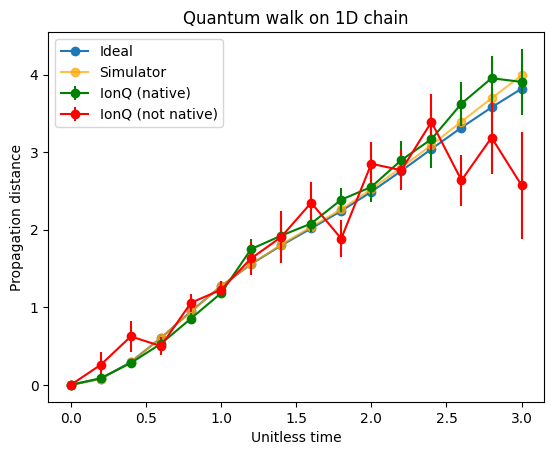

In [175]:
plt.plot(t_vals, propagation_distance_ideal, '-o', label="Ideal")
plt.plot(t_vals, propagation_distance_sim, '-o', label="Simulator", alpha=0.7, color="orange")
plt.errorbar(t_vals[valid_points_ionq_native], propagation_distance_ionq_native[valid_points_ionq_native], propagation_distance_ionq_native_err, fmt='-o', label="IonQ (native)", color="green")
plt.errorbar(t_vals[valid_points_ionq_qis], propagation_distance_ionq_qis[valid_points_ionq_qis], propagation_distance_ionq_qis_err, fmt='-o', label="IonQ (not native)", color="red")
plt.xlabel("Unitless time")
plt.ylabel("Propagation distance")
plt.title("Quantum walk on 1D chain")
plt.legend()
plt.show()

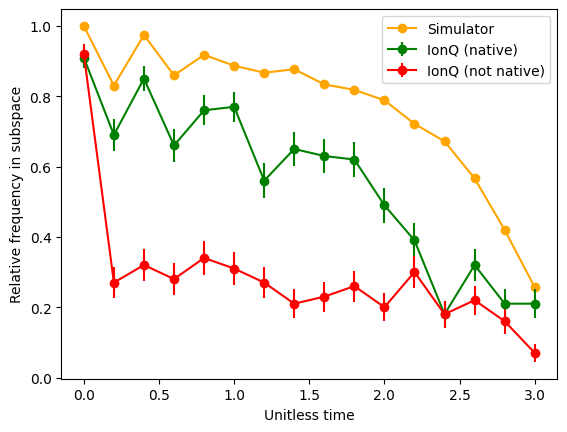

In [176]:
plt.plot(t_vals, np.sum(sim_freq, axis=1), '-o', label="Simulator", color="orange")
plt.errorbar(t_vals, np.sum(ionq_freq_native, axis=1), np.sqrt(np.sum(ionq_freq_native, axis=1) * (1 - np.sum(ionq_freq_native, axis=1)) / (num_shots - 1)), fmt='-o', label="IonQ (native)", color="green")
plt.errorbar(t_vals, np.sum(ionq_freq_qis, axis=1), np.sqrt(np.sum(ionq_freq_qis, axis=1) * (1 - np.sum(ionq_freq_qis, axis=1)) / (num_shots - 1)), fmt='-o', label="IonQ (not native)", color="red")
plt.xlabel("Unitless time")
plt.ylabel("Relative frequency in subspace")
plt.legend()
plt.show()

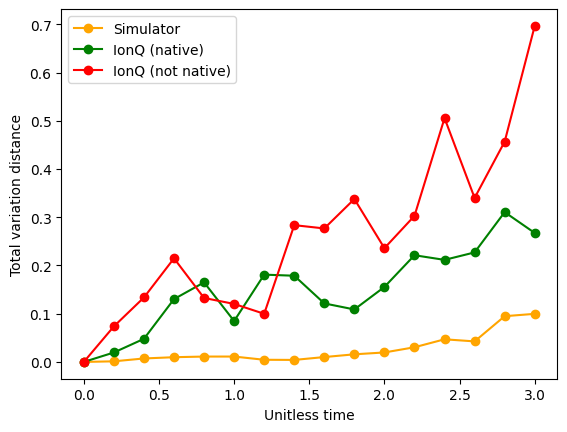

In [177]:
tv_dist_sim = tv_dist(ideal_dist, sim_freq_normalized)
tv_dist_native = tv_dist(ideal_dist, ionq_freq_native_normalized)
tv_dist_qis = tv_dist(ideal_dist, ionq_freq_qis_normalized)

tv_dist_native_err = [tv_dist_err(ideal_dist[i], ionq_freq_native_normalized[i], num_samples_subspace_ionq_native[i]) for i in range(num_time_points)]
tv_dist_qis_err = [tv_dist_err(ideal_dist[i], ionq_freq_qis_normalized[i], num_samples_subspace_ionq_qis[i]) for i in range(num_time_points)]


plt.plot(t_vals, tv_dist_sim, '-o', label="Simulator", color="orange")
plt.plot(t_vals, tv_dist_native, '-o', label="IonQ (native)", color="green")
plt.plot(t_vals, tv_dist_qis, '-o', label="IonQ (not native)", color="red")
# plt.errorbar(t_vals, tv_dist_native, tv_dist_native_err, fmt='-o', label="IonQ (native)", color="green")
# plt.errorbar(t_vals, tv_dist_qis, tv_dist_qis_err, fmt='-o', label="IonQ (not native)", color="red")
plt.legend()
plt.xlabel("Unitless time")
plt.ylabel("Total variation distance")
plt.show()

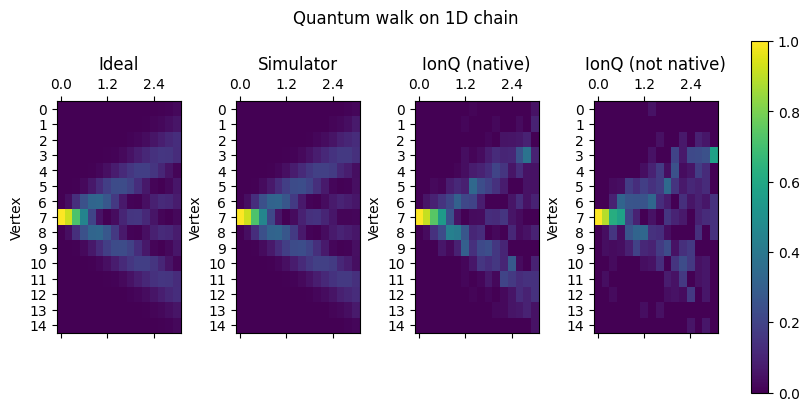

In [178]:

labels = ["Ideal", "Simulator", "IonQ (native)", "IonQ (not native)"]

fig, axs = plt.subplots(1, len(labels), constrained_layout=True, facecolor="white", figsize=(8,4))

max_prob = max(np.max(ideal_dist), np.max(sim_freq_normalized), np.max(ionq_freq_native_normalized), np.max(ionq_freq_qis_normalized))
im = axs[0].matshow(ideal_dist.T, vmin=0, vmax=max_prob)
axs[1].matshow(sim_freq_normalized.T, vmin=0, vmax=max_prob)
axs[2].matshow(ionq_freq_native_normalized.T, vmin=0, vmax=max_prob)
axs[3].matshow(ionq_freq_qis_normalized.T, vmin=0, vmax=max_prob)

aspect = 2

for i in range(len(labels)):
    axs[i].set_aspect(aspect)
    
    axs[i].set_ylabel("Vertex")
    axs[i].set_yticks(np.arange(ideal_dist.shape[1])[::1])
    axs[i].set_yticklabels(np.arange(ideal_dist.shape[1])[::1])
    axs[i].set_title(labels[i])

    axs[i].set_xticks(np.arange(ideal_dist.shape[0])[::6])
    axs[i].set_xticklabels([str(round(float(label), 3)) for label in t_vals[::6]])

fig.colorbar(im, ax=axs.ravel().tolist())
fig.suptitle("Quantum walk on 1D chain")
plt.show()

# Quantum walk on binary tree

In [62]:
DATA_DIR = "experiment_data"
TASK_DIR = "binary_tree"
IONQ_DIR = "ionq_experiments"

CURR_DIR = DATA_DIR
check_and_make_dir(CURR_DIR)
CURR_DIR = join(CURR_DIR, TASK_DIR)
check_and_make_dir(CURR_DIR)
CURR_DIR = join(CURR_DIR, IONQ_DIR)
check_and_make_dir(CURR_DIR)

print(CURR_DIR)

use_real_machine = False
if use_real_machine:
    device = "qpu.aria-1"
    print("Device:", device)
else:
    device = LocalSimulator()

    # device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

    print(f"Using {device.name}")

experiment_data/binary_tree/ionq_experiments
Using StateVectorSimulator


In [63]:
N = 15

dimension = 1
encoding = "one-hot"
n = num_qubits_per_dim(N, encoding)
codewords = get_codewords_1d(n, encoding, periodic=False)
bitstrings = get_bitstrings(N, dimension, encoding)
T = 3.0
num_time_points = 16
t_vals = np.linspace(0, T, num_time_points)

lamb = 4
# Trotter steps
r = 10
num_shots = 100
vertex = 0

use_native_gates = True

experiment_info = {
    "N": N,
    "dimension": dimension,
    "encoding": encoding,
    "T": T,
    "num_time_points": num_time_points,
    "lamb": lamb,
    "r": r,
    "num_shots": num_shots,
    "vertex": vertex,
    "use_native_gates": use_native_gates
}

hash_str = hashlib.md5(json.dumps(experiment_info).encode("utf-8")).hexdigest()
SAVE_DIR = join(CURR_DIR, hash_str)
check_and_make_dir(SAVE_DIR)

print("Save dir:", SAVE_DIR)

with open(join(SAVE_DIR, "experiment_info.json"), "w") as f:
    json.dump(experiment_info, f)
    f.close()

    
# Create binary tree with N nodes
graph = nx.Graph()
for i in np.arange(1, N):
    graph.add_edge(int((i-1)/2), int(i))

A = nx.adjacency_matrix(graph, nodelist=sorted(graph.nodes()))

print("Two qubit gate count:", graph.size() * r)

qpu_job_ids_filename_native = f'''job_ids_{N}_qubits_{r}_steps_qpu_native.json'''
qpu_job_ids_filename_qis = f'''job_ids_{N}_qubits_{r}_steps_qpu_qis.json'''
sim_task_arns_filename = f'''task_arns_{N}_qubits_{r}_steps_simulator.json'''

Save dir: experiment_data/binary_tree/ionq_experiments/07c78c430ad757ab8269cb514064bff4
Two qubit gate count: 140


Submit tasks

In [64]:
if use_real_machine:
    if use_native_gates:
        run_qw(N, dimension, n, encoding, bitstrings, num_time_points, graph, t_vals, TASK_DIR, vertex, lamb, r, num_shots, device, SAVE_DIR, use_real_machine, qpu_job_ids_filename_native, sim_task_arns_filename, use_native_gates)
    else:
        run_qw(N, dimension, n, encoding, bitstrings, num_time_points, graph, t_vals, TASK_DIR, vertex, lamb, r, num_shots, device, SAVE_DIR, use_real_machine, qpu_job_ids_filename_qis, sim_task_arns_filename, use_native_gates)
else:
    sim_freq = run_qw(N, dimension, n, encoding, bitstrings, num_time_points, graph, t_vals, TASK_DIR, vertex, lamb, r, num_shots, device, SAVE_DIR, use_real_machine, qpu_job_ids_filename_native, sim_task_arns_filename, use_native_gates)
    print(np.sum(sim_freq, axis=1))

Unitless time:  0.000
Unitless time:  0.200
Unitless time:  0.400
Unitless time:  0.600
Unitless time:  0.800
Unitless time:  1.000
Unitless time:  1.200
Unitless time:  1.400
Unitless time:  1.600
Unitless time:  1.800
Unitless time:  2.000
Unitless time:  2.200
Unitless time:  2.400
Unitless time:  2.600
Unitless time:  2.800
Unitless time:  3.000
[1.         0.83178356 0.96703214 0.87601842 0.90490401 0.90986645
 0.85270286 0.89471875 0.80507368 0.83474253 0.72514044 0.75682198
 0.59672578 0.59923213 0.36946156 0.17455681]


Get data from completed tasks

In [65]:
# # Get Braket simulator results
# with open(join(SAVE_DIR, sim_task_arns_filename), "r") as f:
#     task_arns = json.load(f)
#     f.close()

# sim_freq = np.zeros((num_time_points, N))
# for i in range(num_time_points):

#     task_arn = task_arns[i]
#     task = AwsQuantumTask(arn=task_arn)
#     result = task.result()
    
#     amplitudes = task.result().values[0]
#     for j in range(N ** dimension):
#         sim_freq[i,j] = np.abs(amplitudes[bitstrings[j]]) ** 2

In [66]:
if use_native_gates:
    ionq_freq_native = get_results(join(SAVE_DIR, qpu_job_ids_filename_native), num_time_points, codewords)
    print(np.sum(ionq_freq_native, axis=1))
else:
    ionq_freq_qis = get_results(join(SAVE_DIR, qpu_job_ids_filename_qis), num_time_points, codewords)
    print(np.sum(ionq_freq_qis, axis=1))

print(np.sum(sim_freq, axis=1))


Getting job: 3da1d77f-14fb-4a27-b015-981e895c76e9
Job status: completed
Getting job: 75b5ac8c-96b0-47ef-b104-b6908b830825
Job status: completed
Getting job: 8f673fe1-e469-4e2b-8411-b7ce744401d5
Job status: completed
Getting job: 1ea75f57-2242-41dc-bbd7-269a61a86662
Job status: completed
Getting job: d8d094e1-6e07-4f6e-b81f-c5d230d43dca
Job status: completed
Getting job: c36e9c89-1ecc-4095-9b1f-82605193d776
Job status: completed
Getting job: 4eacc52e-5b6b-4710-a18b-01318931da4a
Job status: completed
Getting job: 7f82001b-c87d-4c0c-bc9f-41964f608fdb
Job status: completed
Getting job: 2630e029-bb9f-413c-a409-78606e12f9e2
Job status: completed
Getting job: 5cf668e3-0bf4-418a-9baf-fc3e9746ab6f
Job status: completed
Getting job: ac982dc6-05fe-41bb-892b-72411e7cfa18
Job status: completed
Getting job: d3fd3ff7-f88f-4324-bf46-311ae9676f06
Job status: completed
Getting job: 3ee412b6-c2b4-4f33-9a4e-6437a5e2562d
Job status: completed
Getting job: 285fdb63-47b9-4589-85c0-6b2500b04232
Job status: co

Post processing and figures

In [67]:
sim_freq_normalized = np.zeros_like(sim_freq)
for i in range(num_time_points):
    if np.sum(sim_freq[i]) > 0:
        sim_freq_normalized[i] = sim_freq[i] / np.sum(sim_freq[i])

ionq_freq_native_normalized = np.zeros_like(ionq_freq_native)
for i in range(num_time_points):
    if np.sum(ionq_freq_native[i]) > 0:
        ionq_freq_native_normalized[i] = ionq_freq_native[i] / np.sum(ionq_freq_native[i])

ionq_freq_qis_normalized = np.zeros_like(ionq_freq_qis)
for i in range(num_time_points):
    if np.sum(ionq_freq_qis[i]) > 0:
        ionq_freq_qis_normalized[i] = ionq_freq_qis[i] / np.sum(ionq_freq_qis[i])



num_samples_subspace_ionq_native = np.sum(ionq_freq_native, axis=1) * num_shots
num_samples_subspace_ionq_qis = np.sum(ionq_freq_qis, axis=1) * num_shots

In [68]:
# Ground truth
psi_0 = np.zeros(N)
psi_0[vertex] = 1

psi = expm_multiply(-1j * A, psi_0, start=0, stop=T, num=num_time_points)
ideal_dist = np.abs(psi) ** 2

distance_vec = np.zeros(N)
for i in range(N):
    distance_vec[i] = int(np.log2(i + 1))

# Compute propagation distance
propagation_distance_ideal = ideal_dist @ distance_vec
propagation_distance_sim = sim_freq_normalized @ distance_vec
propagation_distance_ionq_native = ionq_freq_native_normalized @ distance_vec
propagation_distance_ionq_qis = ionq_freq_qis_normalized @ distance_vec

# Using unbiased sample variance
propagation_distance_ionq_native_err = np.array(
    [np.sqrt(ionq_freq_native_normalized[i] @ (distance_vec - propagation_distance_ionq_native[i]) ** 2 / (num_samples_subspace_ionq_native[i] - 1)) for i in range(num_time_points)]
)
propagation_distance_ionq_qis_err = np.array(
    [np.sqrt(ionq_freq_qis_normalized[i] @ (distance_vec - propagation_distance_ionq_qis[i]) ** 2 / (num_samples_subspace_ionq_qis[i] - 1)) for i in range(num_time_points)]
)

valid_points_sim = np.sum(sim_freq, axis=1) > 0
valid_points_ionq_native = np.sum(ionq_freq_native, axis=1) > 0
valid_points_ionq_qis = np.sum(ionq_freq_qis, axis=1) > 0

In [72]:
np.save(join(SAVE_DIR, "ideal_dist.npy"), ideal_dist)
np.save(join(SAVE_DIR, "sim_freq_normalized.npy"), sim_freq_normalized)

if use_native_gates:
    np.savez(join(SAVE_DIR, "data.npz"), 
         ideal_dist=ideal_dist,
         sim_freq_normalized=sim_freq_normalized,
         ionq_freq_normalized=ionq_freq_native_normalized,
         num_samples_subspace_ionq=num_samples_subspace_ionq_native)
else:
    np.savez(join(SAVE_DIR, "data.npz"), 
         ideal_dist=ideal_dist,
         sim_freq_normalized=sim_freq_normalized,
         ionq_freq_normalized=ionq_freq_qis_normalized,
         num_samples_subspace_ionq=num_samples_subspace_ionq_qis)


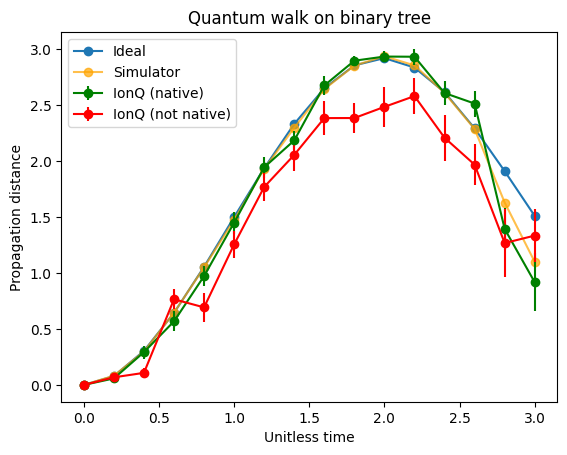

In [156]:
plt.plot(t_vals, propagation_distance_ideal, '-o', label="Ideal")
plt.plot(t_vals, propagation_distance_sim, '-o', label="Simulator", alpha=0.7, color="orange")
plt.errorbar(t_vals[valid_points_ionq_native], propagation_distance_ionq_native[valid_points_ionq_native], propagation_distance_ionq_native_err, fmt='-o', label="IonQ (native)", color="green")
plt.errorbar(t_vals[valid_points_ionq_qis], propagation_distance_ionq_qis[valid_points_ionq_qis], propagation_distance_ionq_qis_err, fmt='-o', label="IonQ (not native)", color="red")
plt.xlabel("Unitless time")
plt.ylabel("Propagation distance")
plt.title("Quantum walk on binary tree")
plt.legend()
plt.show()

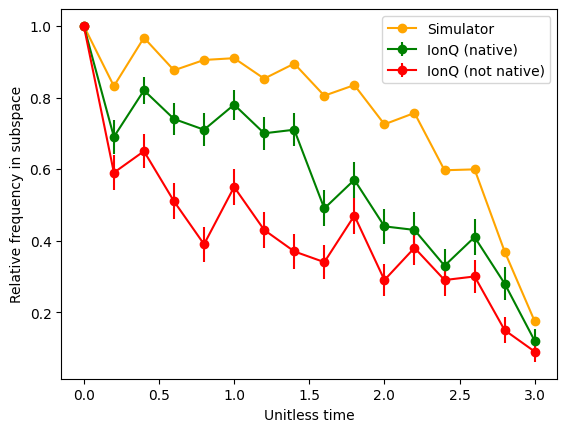

In [157]:
plt.plot(t_vals, np.sum(sim_freq, axis=1), '-o', label="Simulator", color="orange")
plt.errorbar(t_vals, np.sum(ionq_freq_native, axis=1), np.sqrt(np.sum(ionq_freq_native, axis=1) * (1 - np.sum(ionq_freq_native, axis=1)) / (num_shots - 1)), fmt='-o', label="IonQ (native)", color="green")
plt.errorbar(t_vals, np.sum(ionq_freq_qis, axis=1), np.sqrt(np.sum(ionq_freq_qis, axis=1) * (1 - np.sum(ionq_freq_qis, axis=1)) / (num_shots - 1)), fmt='-o', label="IonQ (not native)", color="red")
plt.xlabel("Unitless time")
plt.ylabel("Relative frequency in subspace")
plt.legend()
plt.show()

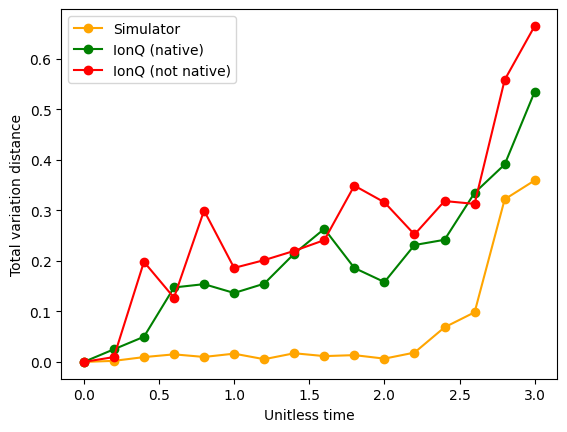

In [158]:
tv_dist_sim = tv_dist(ideal_dist, sim_freq_normalized)
tv_dist_native = tv_dist(ideal_dist, ionq_freq_native_normalized)
tv_dist_qis = tv_dist(ideal_dist, ionq_freq_qis_normalized)

tv_dist_native_err = [tv_dist_err(ideal_dist[i], ionq_freq_native_normalized[i], num_samples_subspace_ionq_native[i]) for i in range(num_time_points)]
tv_dist_qis_err = [tv_dist_err(ideal_dist[i], ionq_freq_qis_normalized[i], num_samples_subspace_ionq_qis[i]) for i in range(num_time_points)]


plt.plot(t_vals, tv_dist_sim, '-o', label="Simulator", color="orange")
plt.plot(t_vals, tv_dist_native, '-o', label="IonQ (native)", color="green")
plt.plot(t_vals, tv_dist_qis, '-o', label="IonQ (not native)", color="red")
# plt.errorbar(t_vals, tv_dist_native, tv_dist_native_err, fmt='-o', label="IonQ (native)", color="green")
# plt.errorbar(t_vals, tv_dist_qis, tv_dist_qis_err, fmt='-o', label="IonQ (not native)", color="red")
plt.legend()
plt.xlabel("Unitless time")
plt.ylabel("Total variation distance")
plt.show()

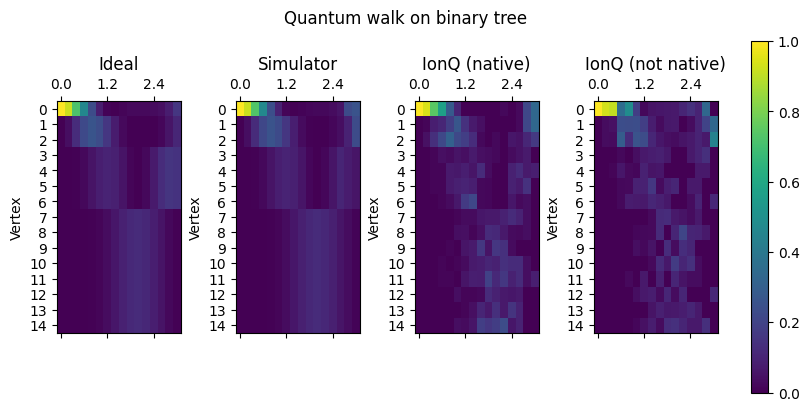

In [159]:

labels = ["Ideal", "Simulator", "IonQ (native)", "IonQ (not native)"]

fig, axs = plt.subplots(1, len(labels), constrained_layout=True, facecolor="white", figsize=(8,4))

max_prob = max(np.max(ideal_dist), np.max(sim_freq_normalized), np.max(ionq_freq_native_normalized), np.max(ionq_freq_qis_normalized))
im = axs[0].matshow(ideal_dist.T, vmin=0, vmax=max_prob)
axs[1].matshow(sim_freq_normalized.T, vmin=0, vmax=max_prob)
axs[2].matshow(ionq_freq_native_normalized.T, vmin=0, vmax=max_prob)
axs[3].matshow(ionq_freq_qis_normalized.T, vmin=0, vmax=max_prob)

aspect = 2

for i in range(len(labels)):
    axs[i].set_aspect(aspect)
    
    axs[i].set_ylabel("Vertex")
    axs[i].set_yticks(np.arange(ideal_dist.shape[1])[::1])
    axs[i].set_yticklabels(np.arange(ideal_dist.shape[1])[::1])
    axs[i].set_title(labels[i])

    axs[i].set_xticks(np.arange(ideal_dist.shape[0])[::6])
    axs[i].set_xticklabels([str(round(float(label), 3)) for label in t_vals[::6]])

fig.colorbar(im, ax=axs.ravel().tolist())
fig.suptitle("Quantum walk on binary tree")
plt.show()

# Quantum walk on glued trees graph

In [52]:
DATA_DIR = "experiment_data"
TASK_DIR = "glued_tree"
IONQ_DIR = "ionq_experiments"

CURR_DIR = DATA_DIR
check_and_make_dir(CURR_DIR)
CURR_DIR = join(CURR_DIR, TASK_DIR)
check_and_make_dir(CURR_DIR)
CURR_DIR = join(CURR_DIR, IONQ_DIR)
check_and_make_dir(CURR_DIR)

print(CURR_DIR)


use_real_machine = False
if use_real_machine:
    device = "qpu.aria-1"
    print("Device:", device)
else:
    device = LocalSimulator()

    # device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

    print(f"Using {device.name}")

experiment_data/glued_tree/ionq_experiments
Using StateVectorSimulator


In [53]:
def get_glued_tree(n):
    seed(0)
    # Two binary trees of height n (2^(n+1) - 1 nodes each glued together
    num_nodes_per_binary_tree = 2 ** (n+1) - 1
    num_nodes = 2 * num_nodes_per_binary_tree
    graph = nx.Graph()

    # Leaves
    leaves_first = []
    leaves_second = []
    for i in range(2 ** n):
        leaves_first.append(2 ** n - 1 + i)
        leaves_second.append(num_nodes - 1 - (2 ** n - 1) - i)

    for i in np.arange(1, num_nodes_per_binary_tree):

        # First binary tree
        graph.add_edge(int((i-1)/2), int(i))

        # Second binary tree
        graph.add_edge(int(num_nodes - 1 - int((i-1)/2)), int(num_nodes - 1 - i))

    # Glue the two trees together
    # Shuffle the leaves to get a random cycle
    shuffle(leaves_first)
    shuffle(leaves_second)

    for i in range(2 ** n):
        graph.add_edge(int(leaves_first[i]), int(leaves_second[i]))
        graph.add_edge(int(leaves_second[i]), int(leaves_first[(i+1) % (2 ** n)]))

    return graph

Nodes in graph: 14
Save dir: experiment_data/glued_tree/ionq_experiments/212948ccab3d0622e07f836cad524c48
Two qubit gate count: 160


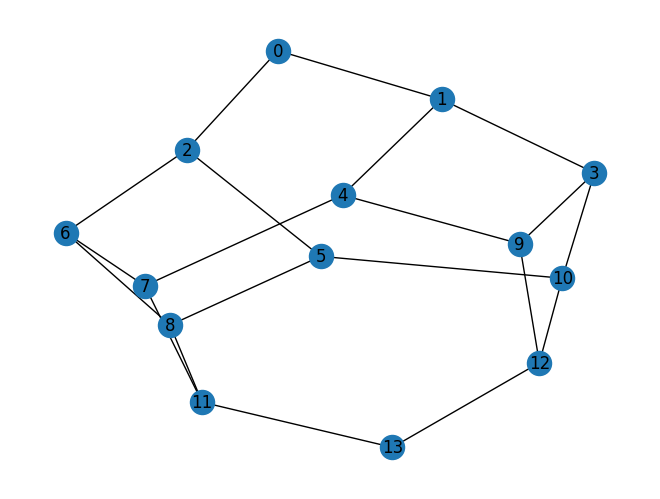

In [54]:
glued_tree_height = 2
N = 2 * (2 ** (glued_tree_height + 1) - 1)
print(f"Nodes in graph: {N}")

dimension = 1
encoding = "one-hot"
n = num_qubits_per_dim(N, encoding=encoding)
codewords = get_codewords_1d(n, encoding, periodic=False)
bitstrings = get_bitstrings(N, dimension, encoding)

# T = 4
# r = 14
# lamb = 4

T = 2.5
r = 8
lamb = 4

num_time_points = 15
t_vals = np.linspace(0, T, num_time_points)

num_shots = 100
vertex = 0

experiment_info = {
    "N": N,
    "dimension": dimension,
    "encoding": encoding,
    "T": T,
    "num_time_points": num_time_points,
    "lamb": lamb,
    "r": r,
    "num_shots": num_shots,
    "vertex": vertex
}

hash_str = hashlib.md5(json.dumps(experiment_info).encode("utf-8")).hexdigest()
SAVE_DIR = join(CURR_DIR, hash_str)
check_and_make_dir(SAVE_DIR)
print("Save dir:", SAVE_DIR)

with open(join(SAVE_DIR, "experiment_info.json"), "w") as f:
    json.dump(experiment_info, f)
    f.close()
    
graph = get_glued_tree(glued_tree_height)

nx.draw(graph, with_labels=True)
A = nx.adjacency_matrix(graph, nodelist=sorted(graph.nodes()))

print("Two qubit gate count:", graph.size() * r)

qpu_job_ids_filename = f'''job_ids_{N}_qubits_{r}_steps_qpu.json'''
sim_task_arns_filename = f'''task_arns_{N}_qubits_{r}_steps_simulator.json'''

Submit tasks

In [55]:
if use_real_machine:
    run_qw(N, dimension, n, encoding, bitstrings, num_time_points, graph, t_vals, TASK_DIR, vertex, lamb, r, num_shots, device, SAVE_DIR, use_real_machine, qpu_job_ids_filename, sim_task_arns_filename)
else:
    sim_freq = run_qw(N, dimension, n, encoding, bitstrings, num_time_points, graph, t_vals, TASK_DIR, vertex, lamb, r, num_shots, device, SAVE_DIR, use_real_machine, qpu_job_ids_filename, sim_task_arns_filename)
    print(np.sum(sim_freq, axis=1))

Unitless time:  0.000
Unitless time:  0.179
Unitless time:  0.357
Unitless time:  0.536
Unitless time:  0.714
Unitless time:  0.893
Unitless time:  1.071
Unitless time:  1.250
Unitless time:  1.429
Unitless time:  1.607
Unitless time:  1.786
Unitless time:  1.964
Unitless time:  2.143
Unitless time:  2.321
Unitless time:  2.500
[1.         0.7600482  0.88781708 0.86226085 0.82203088 0.83312568
 0.80955315 0.79017748 0.73747825 0.66581845 0.67410385 0.40372541
 0.34235914 0.14383063 0.07040802]


Get data from completed tasks

In [56]:
# # Get Braket simulator results
# with open(join(CURR_DIR, sim_task_arns_filename), "r") as f:
#     task_arns = json.load(f)
#     f.close()

# for i in range(num_time_points):

#     task_arn = task_arns[i]
#     task = AwsQuantumTask(arn=task_arn)
#     result = task.result()
    
#     amplitudes = task.result().values[0]
#     for j in range(N ** dimension):
#         sim_freq[i,j] = np.abs(amplitudes[bitstrings[j]]) ** 2

In [57]:
ionq_freq = get_results(join(SAVE_DIR, qpu_job_ids_filename), num_time_points, codewords)

Getting job: 252c2682-2a5f-4c95-b7a8-10931dfa85b1
Job status: completed
Getting job: b0d29fe4-6358-4731-9b59-a9b9ff918326
Job status: completed
Getting job: 9c19c5ab-612d-4b3b-95ef-c776edad001e
Job status: completed
Getting job: 9348d575-79ef-437e-9c4a-39690eaf6252
Job status: completed
Getting job: f71541c3-35f0-4567-a25b-1d521ec88f80
Job status: completed
Getting job: c5e165bd-9c7a-41a8-b084-0e902bdcfe39
Job status: completed
Getting job: e2dd4040-bd32-4f45-881b-da4ec1cbc791
Job status: completed
Getting job: 131207a2-bdab-42db-bdad-1efd4e931307
Job status: completed
Getting job: 4af63271-0f29-49bf-809e-1601ac04fd73
Job status: completed
Getting job: 5e2492fc-667b-47ca-b288-aa25e1240405
Job status: completed
Getting job: 543f624b-80bd-4615-af7c-b4ec15d3c7cf
Job status: completed
Getting job: e11bf928-f2a0-4dc3-96a2-60ec79b299b1
Job status: completed
Getting job: 03e07db4-1f60-4ae2-9f51-287b62156915
Job status: completed
Getting job: 81bc842a-97ed-4e18-aedf-81e340934191
Job status: co

Post processing and figures

In [58]:
sim_freq_normalized = np.zeros_like(sim_freq)
for i in range(num_time_points):
    if np.sum(sim_freq[i]) > 0:
        sim_freq_normalized[i] = sim_freq[i] / np.sum(sim_freq[i])

ionq_freq_normalized = np.zeros_like(ionq_freq)
for i in range(num_time_points):
    if np.sum(ionq_freq[i]) > 0:
        ionq_freq_normalized[i] = ionq_freq[i] / np.sum(ionq_freq[i])

num_samples_subspace_ionq = np.sum(ionq_freq, axis=1) * num_shots

In [59]:
# Ground truth
psi_0 = np.zeros(N)
psi_0[vertex] = 1

psi = expm_multiply(-1j * A, psi_0, start=0, stop=T, num=num_time_points)
ideal_dist = np.abs(psi) ** 2

def get_glued_tree_distance_vec(glued_tree_height):
    
    distance_vec = np.zeros(N)
    for i in range(2 ** (glued_tree_height + 1) - 1):
        distance_vec[i] = int(np.log2(i + 1))
    for i in np.arange(2 ** (glued_tree_height + 1) - 1, N):
        distance_vec[i] = 2 * (glued_tree_height + 1) - 1 - int(np.log2(N - i))

    return distance_vec


distance_vec = get_glued_tree_distance_vec(glued_tree_height)

# Compute propagation distance
propagation_distance_ideal = ideal_dist @ distance_vec
propagation_distance_sim = sim_freq_normalized @ distance_vec
propagation_distance_ionq = ionq_freq_normalized @ distance_vec

# Using unbiased sample variance to compute standard error
propagation_distance_ionq_err = np.array(
    [np.sqrt(ionq_freq_normalized[i] @ (distance_vec - propagation_distance_ionq[i]) ** 2 / (num_samples_subspace_ionq[i] - 1)) for i in range(num_time_points)]
)


valid_points_sim = np.sum(sim_freq, axis=1) > 0
valid_points_ionq = np.sum(ionq_freq, axis=1) > 0


In [61]:
np.savez(join(SAVE_DIR, "data.npz"), 
         ideal_dist=ideal_dist,
         sim_freq_normalized=sim_freq_normalized,
         ionq_freq_normalized=ionq_freq_normalized,
         num_samples_subspace_ionq=num_samples_subspace_ionq)

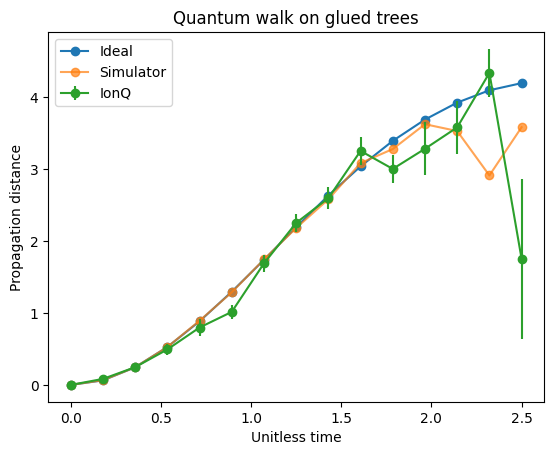

In [851]:
plt.plot(t_vals, propagation_distance_ideal, '-o', label="Ideal")
plt.plot(t_vals, propagation_distance_sim, '-o', label="Simulator", alpha=0.7)
plt.errorbar(t_vals[valid_points_ionq], propagation_distance_ionq[valid_points_ionq], propagation_distance_ionq_err, fmt='-o', label="IonQ")
plt.xlabel("Unitless time")
plt.ylabel("Propagation distance")
plt.title("Quantum walk on glued trees")
plt.legend()
plt.show()

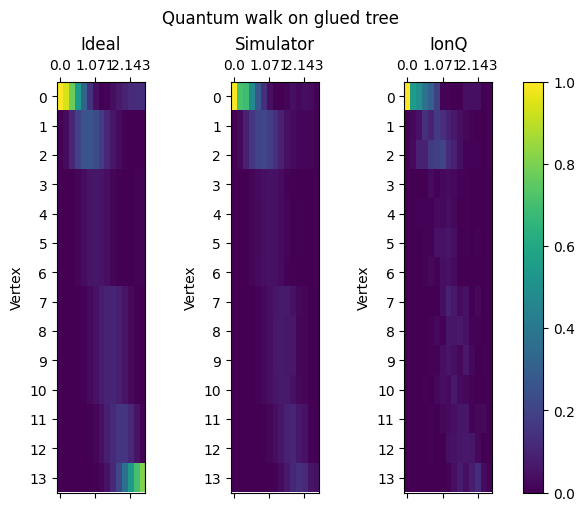

In [852]:

labels = ["Ideal", "Simulator", "IonQ"]

fig, axs = plt.subplots(1, len(labels), constrained_layout=True, facecolor="white", figsize=(6,5))

max_prob = max(np.max(ideal_dist), np.max(sim_freq))#, np.max(ionq_freq))
im = axs[0].matshow(ideal_dist.T, vmin=0, vmax=max_prob)
axs[1].matshow(sim_freq.T, vmin=0, vmax=max_prob)
axs[2].matshow(ionq_freq.T, vmin=0, vmax=max_prob)

aspect = 5

for i in range(len(labels)):
    axs[i].set_aspect(aspect)
    
    axs[i].set_ylabel("Vertex")
    axs[i].set_yticks(np.arange(ideal_dist.shape[1])[::1])
    axs[i].set_yticklabels(np.arange(ideal_dist.shape[1])[::1])
    axs[i].set_title(labels[i])

    axs[i].set_xticks(np.arange(ideal_dist.shape[0])[::6])
    axs[i].set_xticklabels([str(round(float(label), 3)) for label in t_vals[::6]])

fig.colorbar(im, ax=axs.ravel().tolist())
fig.suptitle("Quantum walk on glued tree")
plt.savefig(join("figures", f"glued_tree_heatmap_{n}_qubits.png"), facecolor="white", bbox_inches='tight')
plt.show()

# Spatial search

In [74]:
DATA_DIR = "experiment_data"
TASK_DIR = "spatial_search"
IONQ_DIR = "ionq_experiments"

CURR_DIR = DATA_DIR
check_and_make_dir(CURR_DIR)
CURR_DIR = join(CURR_DIR, TASK_DIR)
check_and_make_dir(CURR_DIR)
CURR_DIR = join(CURR_DIR, IONQ_DIR)
check_and_make_dir(CURR_DIR)

print(CURR_DIR)

use_real_machine = False
if use_real_machine:
    device = "qpu.aria-1"
    # device = "simulator"
    print("Device:", device)
else:
    device = LocalSimulator()

    # device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

    print(f"Using {device.name}")

experiment_data/spatial_search/ionq_experiments
Using StateVectorSimulator


In [75]:
N = 3
dimension = 2
encoding = "one-hot"
n = num_qubits_per_dim(N, encoding)
codewords = get_codewords_2d(n, encoding, periodic=False)
bitstrings = get_bitstrings(N, dimension, encoding)

lamb = 2
T = 5.0
r = 7

# lamb = 4 # N = 3
# T = 6.0 # N = 3 (awaiting results on machine)
# r = 18 # N = 3 (awaiting results on machine)

# lamb = 4 # N = 4
# r = 18 # N = 4

# lamb = 4 # N = 5
# r = 18 # N = 5

num_time_points = 16
t_vals = np.linspace(0, T, num_time_points)
num_shots = 100


use_native_gates = True
use_qiskit_transpiler = False

experiment_info = {
    "N": N,
    "dimension": dimension,
    "encoding": encoding,
    "T": T,
    "num_time_points": num_time_points,
    "lamb": lamb,
    "r": r,
    "num_shots": num_shots,
    "use_native_gates": use_native_gates,
    "use_qiskit_transpiler": use_qiskit_transpiler
}

hash_str = hashlib.md5(json.dumps(experiment_info).encode("utf-8")).hexdigest()
SAVE_DIR = join(CURR_DIR, hash_str)
check_and_make_dir(SAVE_DIR)

print("Save dir:", SAVE_DIR)

with open(join(SAVE_DIR, "experiment_info.json"), "w") as f:
    json.dump(experiment_info, f)
    f.close()

name = "spatial_search"
qpu_job_ids_filename = f'job_ids_qpu.json'
sim_task_arns_filename = f'task_arns_simulator.json'

Save dir: experiment_data/spatial_search/ionq_experiments/48cd85c1b6226bc31bfe53b425fb0218


In [76]:
# Compute the optimal gamma
L = get_laplacian_lattice(N, dimension)
marked_vertex_1 = np.zeros(N)
marked_vertex_1[0] = 1
marked_vertex_2 = np.zeros(N)
marked_vertex_2[N-1] = 1

marked_vertex = np.kron(marked_vertex_2, marked_vertex_1)
H_oracle = -csc_matrix(np.outer(marked_vertex, marked_vertex))
# Sign is flipped here; this function minimizes the difference between the two largest eigenvalues of gamma * L + H_oracle
gamma = scipy_get_optimal_gamma(L, -H_oracle, 0.3)
print(f"gamma = {gamma}")

gamma = 0.49399952888488785


In [77]:
amplitudes_input = np.ones(N)
amplitudes_input /= np.linalg.norm(amplitudes_input)
circuit = state_prep_braket(N, dimension, amplitudes_input, encoding)
circuit.add_circuit(get_spatial_search_circuit_braket(N, lamb, gamma, T, r, encoding))

instructions = get_circuit_from_braket(circuit)

if use_qiskit_transpiler:
    transpiled_circuit = transpile(get_qiskit_circuit(n * dimension, instructions),
                                basis_gates=["rx", "ry", "rz", "rxx", "ryy"],
                                optimization_level=3)
    instructions = get_circuit_from_qiskit(transpiled_circuit)

job = get_ionq_job_json("", N, dimension, num_shots, device, encoding, instructions, use_native_gates)

One qubit gates: 114
Two qubit gates: 83


Submit tasks

In [116]:
if use_real_machine:
    run_ss(N, dimension, encoding, bitstrings, num_time_points, t_vals, TASK_DIR, 
           gamma, lamb, r, num_shots, device, SAVE_DIR, use_real_machine, 
           qpu_job_ids_filename, sim_task_arns_filename,
           use_native_gates=use_native_gates, use_qiskit_transpiler=use_qiskit_transpiler)
else:
    sim_freq = run_ss(N, dimension, encoding, bitstrings, num_time_points, t_vals, TASK_DIR, 
           gamma, lamb, r, num_shots, device, SAVE_DIR, use_real_machine, 
           qpu_job_ids_filename, sim_task_arns_filename)
    print(np.sum(sim_freq, axis=1))

Unitless time:  0.000
Unitless time:  0.333
Unitless time:  0.667
Unitless time:  1.000
Unitless time:  1.333
Unitless time:  1.667
Unitless time:  2.000
Unitless time:  2.333
Unitless time:  2.667
Unitless time:  3.000
Unitless time:  3.333
Unitless time:  3.667
Unitless time:  4.000
Unitless time:  4.333
Unitless time:  4.667
Unitless time:  5.000
[1.         0.94895319 0.93730231 0.99515185 0.95765915 0.91460759
 0.96557106 0.97013149 0.91746416 0.92870452 0.9496634  0.92733589
 0.91443272 0.88157965 0.84054701 0.87784373]


Get data from completed tasks

In [117]:
ionq_freq = get_results(join(SAVE_DIR, qpu_job_ids_filename), num_time_points, codewords)

Getting job: 26060be0-98fa-4886-b717-c351ec50e09d
Job status: completed
Getting job: 578c583b-0315-4545-bf8b-8fb22b30a24a
Job status: completed
Getting job: f992c985-ef6a-4a51-a4ea-bc4b85bca863
Job status: completed
Getting job: 32a41c87-e4d8-472c-b5a7-5f03f07af67c
Job status: completed
Getting job: adf1b45a-e303-4a2b-9e82-5d77dbd5eb9b
Job status: completed
Getting job: 9ff74451-d7ca-4ca1-952c-69c56d590698
Job status: completed
Getting job: 36c1a789-ad73-4d91-b9ab-f47dc7920dde
Job status: completed
Getting job: 79eefe5d-c802-458f-8b0c-072f7ca72d70
Job status: completed
Getting job: 05750bba-59df-4d84-87e4-5c8e3c448b72
Job status: completed
Getting job: fbc4e8a5-6bd3-4b2e-b948-5eeb6fe90635
Job status: completed
Getting job: 1fd173da-7ae2-4ff9-b215-0395a7880e6b
Job status: completed
Getting job: 1b36e43d-674f-40bc-b6aa-b9e7983bd0b5
Job status: completed
Getting job: a4733ecb-bb8a-4a94-a01d-66d3a6777467
Job status: completed
Getting job: b2a7e3bb-e650-41dd-a202-82837693e25e
Job status: co

In [118]:
print(np.sum(ionq_freq, axis=1))

[0.87 0.67 0.67 0.67 0.72 0.67 0.67 0.65 0.7  0.62 0.57 0.53 0.41 0.56
 0.47 0.54]


Post processing and figures

In [119]:
# Ideal
psi_0 = np.ones(N ** dimension, dtype=np.complex64)
psi_0 /= np.linalg.norm(psi_0)

H = -gamma * L + H_oracle
psi = expm_multiply(-1j * H, psi_0, start=0, stop=T, num=num_time_points)
ideal_success_probability = np.abs(psi[:, N ** dimension - N]) ** 2

In [120]:
sim_freq_normalized = np.zeros_like(sim_freq)
for i in range(num_time_points):
    if np.sum(sim_freq[i]) > 0:
        sim_freq_normalized[i] = sim_freq[i] / np.sum(sim_freq[i])

ionq_freq_normalized = np.zeros_like(ionq_freq)
for i in range(num_time_points):
    if np.sum(ionq_freq[i]) > 0:
        ionq_freq_normalized[i] = ionq_freq[i] / np.sum(ionq_freq[i])

num_samples_subspace_ionq = np.sum(ionq_freq, axis=1) * num_shots

valid_points_sim = np.sum(sim_freq, axis=1) > 0
valid_points_ionq = num_samples_subspace_ionq > 0

success_prob_sim = sim_freq_normalized[:,-N]
success_prob_ionq = ionq_freq_normalized[:,-N]
err_ionq = np.sqrt(success_prob_ionq * (1 - success_prob_ionq) / (num_samples_subspace_ionq - 1))


In [121]:
np.savez(join(SAVE_DIR, "data.npz"), 
         ideal_dist=ideal_dist,
         sim_freq_normalized=sim_freq_normalized,
         ionq_freq_normalized=ionq_freq_normalized,
         num_samples_subspace_ionq=num_samples_subspace_ionq)

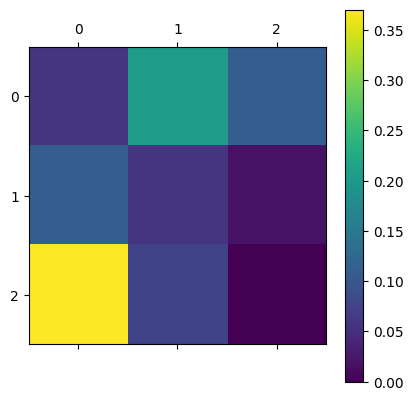

In [122]:
plt.matshow(ionq_freq_normalized[-1].reshape((N,N)))
plt.colorbar()
plt.show()

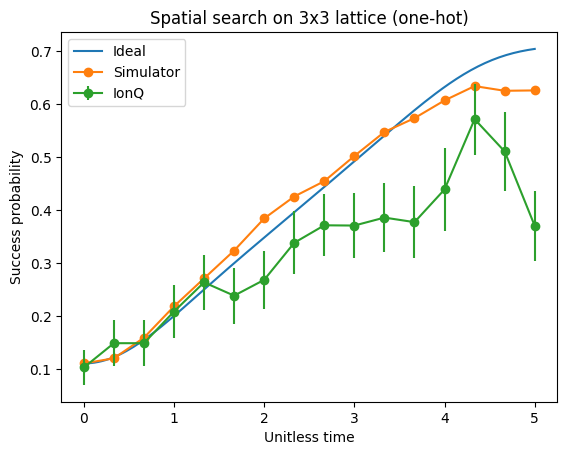

In [91]:

plt.title(f"Spatial search on {N}x{N} lattice ({encoding})")
plt.plot(np.linspace(0, T, num_time_points), ideal_success_probability, label="Ideal")
plt.plot(t_vals, success_prob_sim, '-o', label="Simulator")
plt.errorbar(t_vals[valid_points_ionq], success_prob_ionq[valid_points_ionq], err_ionq, fmt='-o', label="IonQ")
plt.ylabel("Success probability")
plt.xlabel("Unitless time")
plt.legend()
plt.show()

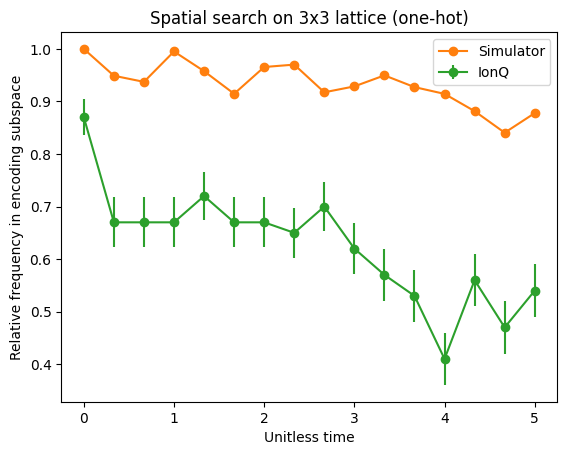

In [1385]:
plt.plot(t_vals, np.sum(sim_freq, axis=1), '-o', label="Simulator", color="#ff7f0e")
plt.errorbar(t_vals, np.sum(ionq_freq, axis=1), np.sqrt(np.sum(ionq_freq, axis=1) * (1 - np.sum(ionq_freq, axis=1)) / (num_shots - 1)), fmt='-o', label="IonQ", color="#2ca02c")
plt.xlabel("Unitless time")
plt.ylabel("Relative frequency in encoding subspace")
plt.title(f"Spatial search on {N}x{N} lattice ({encoding})")
plt.legend()
plt.show()

# Real space quantum simulation

In [78]:
DATA_DIR = "experiment_data"
TASK_DIR = "real_space_quantum_simulation"
IONQ_DIR = "ionq_experiments"

CURR_DIR = DATA_DIR
check_and_make_dir(CURR_DIR)
CURR_DIR = join(CURR_DIR, TASK_DIR)
check_and_make_dir(CURR_DIR)
CURR_DIR = join(CURR_DIR, IONQ_DIR)
check_and_make_dir(CURR_DIR)

print(CURR_DIR)

use_real_machine = False
if use_real_machine:
    device = "qpu.aria-1"   
    # device = "simulator"
    print("Device:", device)
else:
    device = LocalSimulator()

    # device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

    print(f"Using {device.name}")

experiment_data/real_space_quantum_simulation/ionq_experiments
Using StateVectorSimulator


In [79]:
N = 8
dimension = 2
encoding = "unary"
n = num_qubits_per_dim(N, encoding)
codewords = get_codewords_2d(n, encoding, periodic=False)
bitstrings = get_bitstrings(N, dimension, encoding)

lamb = 1.5
T = 3.5
r = 7
sigma = 0.2 # std dev of gaussian initial state
centered_differences_order = 2
assert centered_differences_order == 2 or centered_differences_order == 4
h = 1

num_time_points = 16
t_vals = np.linspace(0, T, num_time_points)
num_shots = 200

use_native_gates = True
use_qiskit_transpiler = True

experiment_info = {
    "N": N,
    "dimension": dimension,
    "encoding": encoding,
    "T": T,
    "num_time_points": num_time_points,
    "lamb": lamb,
    "r": r,
    "sigma": sigma,
    "centered_differences_order": centered_differences_order,
    "num_shots": num_shots,
    "use_native_gates": use_native_gates,
    "use_qiskit_transpiler": use_qiskit_transpiler
}

hash_str = hashlib.md5(json.dumps(experiment_info).encode("utf-8")).hexdigest()
SAVE_DIR = join(CURR_DIR, hash_str)
check_and_make_dir(SAVE_DIR)

print("Save dir:", SAVE_DIR)

with open(join(SAVE_DIR, "experiment_info.json"), "w") as f:
    json.dump(experiment_info, f)
    f.close()


qpu_job_ids_filename = f'''job_ids_qpu.json'''
sim_task_arns_filename = f'''task_arns_simulator.json'''

Save dir: experiment_data/real_space_quantum_simulation/ionq_experiments/a88f91a9f7447ac1f166152e23e6885d


In [80]:
# gaussian intial state
amplitudes_input = np.exp(-0.5 * (np.linspace(0, 1, N) - 0.5) ** 2 / sigma ** 2)
amplitudes_input /= np.linalg.norm(amplitudes_input, ord=2)

# use braket simulator and get amplitudes of state vector
circuit = state_prep_braket(N, dimension, amplitudes_input, encoding)
circuit.add_circuit(get_real_space_qsim_circuit_braket(N, lamb, 3.5, 7, centered_differences_order, encoding))
instructions = get_circuit_from_braket(circuit)

# if use_qiskit_transpiler:
transpiled_circuit = transpile(get_qiskit_circuit(n * dimension, instructions),
                            basis_gates=["rx", "ry", "rz", "rxx", "ryy"],
                            optimization_level=3)
instructions = get_circuit_from_qiskit(transpiled_circuit)
    
# Create the job json and save it
job = get_ionq_job_json("test", N, dimension, num_shots, device, encoding, instructions, use_native_gates)

One qubit gates: 246
Two qubit gates: 96


Submit tasks

In [81]:
if use_real_machine:
    run_real_space_qsim(N, dimension, encoding, bitstrings, num_time_points, t_vals, TASK_DIR, 
           lamb, r, sigma, centered_differences_order, num_shots, device, SAVE_DIR, use_real_machine, 
           qpu_job_ids_filename, sim_task_arns_filename,
           use_native_gates=use_native_gates, use_qiskit_transpiler=use_qiskit_transpiler)
else:
    sim_freq = run_real_space_qsim(N, dimension, encoding, bitstrings, num_time_points, t_vals, TASK_DIR, 
           lamb, r, sigma, centered_differences_order, num_shots, device, SAVE_DIR, use_real_machine, 
           qpu_job_ids_filename, sim_task_arns_filename)
    print(np.sum(sim_freq, axis=1))

Unitless time:  0.000
Unitless time:  0.233
Unitless time:  0.467
Unitless time:  0.700
Unitless time:  0.933
Unitless time:  1.167
Unitless time:  1.400
Unitless time:  1.633
Unitless time:  1.867
Unitless time:  2.100
Unitless time:  2.333
Unitless time:  2.567
Unitless time:  2.800
Unitless time:  3.033
Unitless time:  3.267
Unitless time:  3.500
[1.         0.86894082 0.73812487 0.81832801 0.95286779 0.92282859
 0.84655914 0.85966515 0.91104412 0.93548208 0.94425723 0.95233406
 0.96129105 0.97512983 0.9891175  0.9960935 ]


Get data from completed tasks

In [82]:
ionq_freq = get_results(join(SAVE_DIR, qpu_job_ids_filename), num_time_points, codewords)

Getting job: 658562b0-c33b-4601-b4a3-c172b60e20f4
Job status: completed
Getting job: 3c78558d-ab53-4d9d-af69-cd1f7349bb2c
Job status: completed
Getting job: 25a6a01f-c09c-4a37-8b97-35ff9a417410
Job status: completed
Getting job: 6e260c83-8a41-4be3-9fc9-8dccc8d1d980
Job status: completed
Getting job: 8b9fd6ba-1f86-476b-afe7-e155093072b5
Job status: completed
Getting job: 6d6936d9-71b6-4175-b363-23c1ec0e73a3
Job status: completed
Getting job: 186eb206-17ea-48e2-865f-7a92fd7bf091
Job status: completed
Getting job: 9747bcb3-4f2c-47e2-9c43-679531fd5793
Job status: completed
Getting job: e35d14fe-bc8a-4593-9c7b-37959a744600
Job status: completed
Getting job: 98aeb5ad-f21c-4331-a22e-8f0e4b09f7b9
Job status: completed
Getting job: 2b1bfb45-4021-4cfa-a02b-bf4d1864800f
Job status: completed
Getting job: ba5eb08a-1332-462c-9c61-12aa4162e976
Job status: completed
Getting job: d2a7e058-1609-4320-b6e5-021ae9925ea7
Job status: completed
Getting job: 23757d88-04af-4ad1-a25b-3d0c2bf1a0b3
Job status: co

Post processing and figures

In [83]:
np.sum(ionq_freq, axis=1)

array([0.86 , 0.605, 0.49 , 0.605, 0.645, 0.535, 0.52 , 0.555, 0.555,
       0.555, 0.415, 0.365, 0.43 , 0.43 , 0.48 , 0.52 ])

In [84]:
sim_freq_normalized = np.zeros_like(sim_freq)
for i in range(num_time_points):
    if np.sum(sim_freq[i]) > 0:
        sim_freq_normalized[i] = sim_freq[i] / np.sum(sim_freq[i])

ionq_freq_normalized = np.zeros_like(ionq_freq)
for i in range(num_time_points):
    if np.sum(ionq_freq[i]) > 0:
        ionq_freq_normalized[i] = ionq_freq[i] / np.sum(ionq_freq[i])

num_samples_subspace_ionq = np.sum(ionq_freq, axis=1) * num_shots

valid_points_sim = np.sum(sim_freq, axis=1) > 0
valid_points_ionq = num_samples_subspace_ionq > 0

pos_0_sim = np.sum(sim_freq_normalized.reshape(num_time_points, N, N), axis=2) @ np.linspace(0, 1, N)
pos_1_sim = np.sum(sim_freq_normalized.reshape(num_time_points, N, N), axis=1) @ np.linspace(0, 1, N)

pos_0_ionq = np.sum(ionq_freq_normalized.reshape(num_time_points, N, N), axis=2) @ np.linspace(0, 1, N)
pos_1_ionq = np.sum(ionq_freq_normalized.reshape(num_time_points, N, N), axis=1) @ np.linspace(0, 1, N)

pos_0_ionq_err = np.array(
    [np.sqrt(np.sum(ionq_freq_normalized.reshape(num_time_points, N, N), axis=2)[i] @ (np.linspace(0, 1, N) - np.sum(ionq_freq_normalized.reshape(num_time_points, N, N), axis=2)[i]) ** 2 / (num_samples_subspace_ionq[i] - 1)) for i in range(num_time_points)]
)
pos_1_ionq_error = np.array(
    [np.sqrt(np.sum(ionq_freq_normalized.reshape(num_time_points, N, N), axis=1)[i] @ (np.linspace(0, 1, N) - np.sum(ionq_freq_normalized.reshape(num_time_points, N, N), axis=1)[i]) ** 2 / (num_samples_subspace_ionq[i] - 1)) for i in range(num_time_points)]
)

In [85]:
# Ideal
gaussian = np.exp(-0.5 * (np.linspace(0, 1, N, dtype=np.complex64) - 0.5) ** 2 / sigma ** 2)
psi_0 = np.kron(gaussian, gaussian)
psi_0 /= np.linalg.norm(psi_0)

if centered_differences_order == 2:
    L_1D = -0.5 * diags([np.ones(N-1), np.ones(N-1)], offsets=[1, -1]) / (h ** 2)
elif centered_differences_order == 4:
    L_1D = -0.5 * diags([(-1/12) * np.ones(N-2), (4/3) * np.ones(N-1), (4/3) * np.ones(N-1), (-1/12) * np.ones(N-2)], offsets=[2, 1, -1, -2]) / (h ** 2)
L = kron(identity(N), L_1D) + kron(L_1D, identity(N))
V = kron(identity(N), diags(np.linspace(0, 1, N))) - kron(diags(np.linspace(0, 1, N)), identity(N))
H = L + V

psi = expm_multiply(-1j * H, psi_0, start=0, stop=T, num=num_time_points)
ideal_dist = np.abs(psi) ** 2

pos_0 = np.sum(ideal_dist.reshape(num_time_points, N, N), axis=1) @ np.linspace(0, 1, N)
pos_1 = np.sum(ideal_dist.reshape(num_time_points, N, N), axis=2) @ np.linspace(0, 1, N)


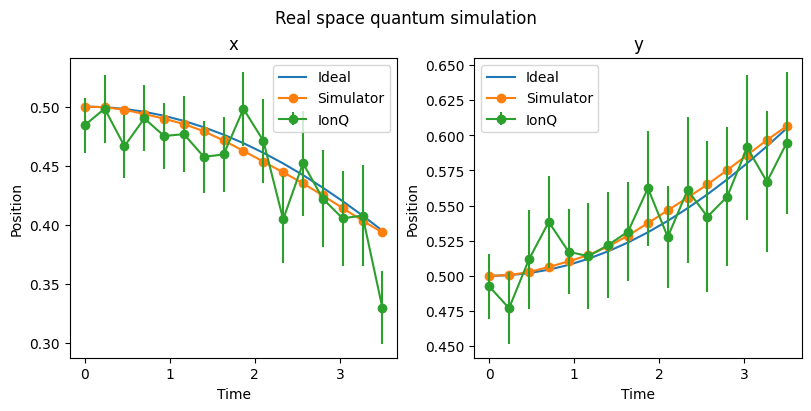

In [86]:

labels = ["x", "y"]

fig, axs = plt.subplots(1, len(labels), constrained_layout=True, facecolor="white", figsize=(8,4))

axs[0].plot(np.linspace(0, T, num_time_points), pos_0, label="Ideal")
axs[1].plot(np.linspace(0, T, num_time_points), pos_1, label="Ideal")

axs[0].plot(t_vals, pos_0_sim, '-o', label="Simulator")
axs[1].plot(t_vals, pos_1_sim, '-o', label="Simulator")

axs[0].errorbar(t_vals, pos_0_ionq, pos_0_ionq_err, fmt='-o', label="IonQ")
axs[1].errorbar(t_vals, pos_1_ionq, pos_1_ionq_error, fmt='-o', label="IonQ")

for i in range(2):
    
    axs[i].set_ylabel("Position")
    axs[i].set_title(labels[i])

    axs[i].set_xlabel("Time")
    axs[i].legend()

fig.suptitle("Real space quantum simulation")
plt.show()

In [107]:
np.savez(join(SAVE_DIR, "data.npz"), 
         ideal_dist=ideal_dist,
         sim_freq_normalized=sim_freq_normalized,
         ionq_freq_normalized=ionq_freq_normalized,
         num_samples_subspace_ionq=num_samples_subspace_ionq)